# TP 2 - Grupo 7

André Filipe Dourado Pinheiro - A108473

Tiago Silva Costa - A108657

## Problema 1 - Circuitos 

Construa uma resolução das seguintes questões a partir de “inputs” do problema: os parâmetros $\kappa,n$ e de probabilidade de falha $\varepsilon$ restrita apenas às “gates” and.


1. Construa algoritmos para, sob “inputs” do segredo $z\in\{0,1\}^n$ e da “chave mestra” $s\in\{0,1\}^\kappa$, construa o circuito. Adicionalmente a partir deste circuito, construa o modelo SMT do circuito com falhas.
2. Usando o modelo acima, tente construir uma possível estimativa  para $z$ numa execução com falhas não nulas; isto é, encontrar
    1. $z'\in \{0,1\}^n$  que é raíz de todos os polinómios que formam o circuito e 
    2. uma situação de falhas não nulas em “gates” and  que conduz a essa estimativa.
3. Conhecido $z\in\{0,1\}^n$ pretende-se maximizar a probabilidade de falhas and sem que o “output” $0^n$ seja alterado.


## Modelação

Com o objetivo de resolver o problema proposto, optou-se pela utilização do módulo `pysmt.shortcuts`, que oferece diversos recursos voltados ao uso de SMT Solvers. Além disso, os tipos de dados específicos do Solver são importados a partir do módulo `pysmt.typing`.

Por fim, vamos utilizar outros módulos para facilitar a visualização do circuito.

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import BOOL
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Implementação

### Geração do circuito

Queremos construir algoritmos que a partir do segredo $z\in\{0,1\}^n$ e da “chave mestra” $s\in\{0,1\}^\kappa$, construa um circuito.

Começemos por implementar as seguintes funções auxiliares:
1. `bits_to_bytes` - Converte *array* binário (uint8) para *bytes* compactados
2. `bytes_to_bits` - Converte *bytes* compactados para *array* binário (uint8)
3. `make_polynom` - Gera polinômio binário como array de uint8
3. `sum_1` - Retorna 1 se o número de posições onde $a$ e $x$ são ambos $1$ for ímpar, e 0 se for par.
4. `maj` - Calcula o $\operatorname{maj}_1$ dadas $3$ entradas.

In [2]:
# Funções auxiliares para bits para bytes
def bits_to_bytes(bits):
    """Converte array binário (uint8) -> bytes compactados"""
    return np.packbits(bits)

def bytes_to_bits(packed, length=None):
    """Converte bytes compactados -> array binário (uint8)"""
    bits = np.unpackbits(packed)
    if length is not None:
        bits = bits[:length]
    return bits

# Geração dos polinómios
def make_polynom(n, rng, low=0, high=1):
    """Gera polinômio binário como array de uint8"""
    return rng.randint(low, high + 1, size=n, dtype=np.uint8)

# Funções de avaliação
def sum_1(a, x):
    """Retorna 1 se o número de posições onde $a$ e $x$ são ambos $1$ for ímpar, e 0 se for par"""
    soma = np.sum(a*x)
    return np.uint8(soma % 2)

def maj(a, b, c):
    """Calcula maj_1(a,b,c)"""
    return (a&b) | (a&c) | (b&c)


Além disso, vamos criar as seguintes funções auxiliares para trabalhar com expressões simbólicas:

1. `sum_1_symb` - Expressão simbólica para $\langle a \cdot x \rangle = \bigoplus_{a_i = 1} x_i$
2. `xor_n`- Acumula Xor sobre uma lista de termos pySMT
3. `maj_symb` - Expressão simbólica para $\operatorname{maj}_1$

In [3]:
def sum_1_symb(a, x_vars):
    """Expressão simbólica para <a, x> = XOR_{i: a_i = 1} x_i"""
    terms = [x_vars[i] for i in range(len(a)) if int(a[i]) == 1]
    if not terms:
        return FALSE()
    if len(terms) == 1:
        return terms[0]
    expr = terms[0]
    for t in terms[1:]:
        expr = Xor(expr, t)
    return expr


def xor_n(terms):
    """XOR n-ário: acumula Xor sobre uma lista de termos pySMT."""
    if not terms:
        return FALSE()
    if len(terms) == 1:
        return terms[0]
    expr = terms[0]
    for t in terms[1:]:
        expr = Xor(expr, t)
    return expr

def maj_symb(p, q, r):
    """Expressão simbólica para maj_1"""
    return Or(And(p, q), And(p, r), And(q, r))


Com o material que já temos, podemos construir o circuito e realizar o cálculo do vetor dos *offsets*.

In [4]:
def eval_f_numeric(p, x, f_vals):
    """Avalia f(p, x) numericamente: o xor <a·x> xor (<b·x> AND <c·x>), com possível falha em AND"""
    o, a, b, c = p
    bx = int(sum_1(b, x))
    cx = int(sum_1(c, x))

    bx, cx = sum_1(b, x), sum_1(c, x)
    t = []
    for f in f_vals:
        val = bx & cx
        if f:  # falha stuck-at-1
            val = 1-val
        t.append(val)
    maj_val = maj(t[0], t[1], t[2])
    return int(o ^ sum_1(a, x) ^ maj_val)
    

Vamos definir $n,k,\varepsilon$ como os *inputs* iniciais do algoritmo. 

O número de sub-circuitos será dado por $m$, que será inicialmente igual a $n$.

Como depois queremos constrir um modelo SMT do circuito com falhas, vamos definir $\varepsilon = 1$.

In [5]:
n = 6  # dimensão e tamanho do polinómio e do segredo
k = 8  # parâmetro de segurança e tamanho da seed
epsilon = 1  # fração máxima de falhas permitida
m = n  # número de polinómios

Em seguida, vamos gerar de forma aleatória o seguinte: 

1. *Seed*, representada por $s$.
2. Segredo, representada por $z$.
3. Polinômios binários pseudoaleatórios, representados pelo $p_i = (0,a_i,b_i,c_i)$.

In [6]:
# Gerar seed s
s_bits = np.random.randint(0, 2, size=k, dtype=np.uint8)
s_packed = bits_to_bytes(s_bits)

print("Seed (bits):", s_bits)
print("Seed (bytes):", s_packed)

# Seed compactada para inicializar RNG
rng = np.random.RandomState(s_packed)  

# Geração dos polinómios
def make_polynom(n, rng, low=0, high=1):
    """Gera polinômio binário como array de uint8"""
    return rng.randint(low, high + 1, size=n, dtype=np.uint8)

a_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
b_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
c_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)

# Segredo z
z_bits = make_polynom(n, rng)
z_packed = bits_to_bytes(z_bits)

print("z (bits) =", z_bits)
print("z (bytes) =", z_packed)

p0_list = [(0, a_list[i], b_list[i], c_list[i]) for i in range(m)]

Seed (bits): [0 1 0 0 0 1 1 0]
Seed (bytes): [70]
z (bits) = [1 1 1 0 0 1]
z (bytes) = [228]


Portanto, a nossa chave pública será.

In [7]:
# Gerar chave pública
o_list = [eval_f_numeric(p0_list[i], z_bits, [0,0,0]) for i in range(m)]
q = (o_list, s_packed)
print("Chave pública q (o_list, seed_packed) =", (o_list, s_packed))

Chave pública q (o_list, seed_packed) = ([1, 0, 1, 1, 1, 1], array([70], dtype=uint8))


Por fim, podemos verificar se $$f(p;z)=0$$

In [8]:
# Criar p_list igual a p0_list mas com o = o_list
p_list = [(int(o_list[i]), a_list[i], b_list[i], c_list[i]) for i in range(m)]

# Avaliar f sobre p_list com o segredo z_bits (deve ser só 0s)
o_list_from_p = [eval_f_numeric(p_list[i], z_bits,[0,0,0]) for i in range(m)]
print("o_list a partir p_list:", o_list_from_p)

o_list a partir p_list: [0, 0, 0, 0, 0, 0]


### Recuperação da chave privada

A partir do circuito, vamos construir o modelo SMT do circuito com falhas.

Para isso, começemos por, a partir da chave pública $(o,s)$, recuperar os polinómios.

In [9]:
# Reconstrução de z via SMT
o_public, s_recovered = q
s_recovered_bits = bytes_to_bits(s_recovered, length=k)

# Regenerar polinómios com a mesma seed
rng = np.random.RandomState(s_recovered)
a_list_r = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
b_list_r = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
c_list_r = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)


#### Variáveis de decisão

Vamos definir as seguites variáveis de decisão booleanas no modelo SMT:

1. Sejam $z_{i} \in \{0,1\}$, no qual o solver tenta reconstruir.
2. Seja $f_{i,j} \in \{0,1\}$, falha no i-ésimo circuito, na j-ésima porta AND, responsável por indicar se a operação AND é invertida.


In [10]:
# Variáveis booleanas simbólicas
z_vars = [Symbol(f"z{i}", BOOL) for i in range(n)]
f_vars = [[Symbol(f"f{i}_{j}", BOOL) for j in range(3)] for i in range(m)]   # simboliza erros no AND

#### Restrições 

Vamos armazenar as restrições na seguinte lista:



In [11]:
# construir constraints SMT
constraints = []

Formalizamos a restrições do problema

1. Respeitar a cardinalidade das falhas, ou seja, o número de falhas permitido.

$$\sum_{i=0}^{m-1} \sum_{j=0}^{2} f_{i,j} < \left\lfloor 3m\varepsilon \right\rfloor$$

In [12]:
# Limitar número de falhas permitido (até epsilon * m)
max_faults = int(np.floor(epsilon * m * 3))
fault_terms = [Ite(f_vars[i][j], Int(1), Int(0)) for i in range(m) for j in range(3)]
constraints.append(LE(Plus(fault_terms), Int(max_faults)))

2. As restrições lógicas do circuito devem ser respeitadas, isto é, 
$$\forall i \in \{0, \dots, m-1\}, \quad o_i = \langle a_i \cdot z \rangle \oplus \operatorname{maj}_1 \big(\langle b_i \cdot z \rangle \hat{\times}_{f_{i,0}} \langle c_i \cdot z \rangle, \langle  b_i \cdot z \rangle \hat{\times}_{f_{i,1}} \langle c_i \cdot z \rangle, \langle  b_i \cdot z \rangle \hat{\times}_{f_{i,2}} \langle c_i \cdot z \rangle\big)$$

onde

$$\langle a \cdot x \rangle = \bigoplus_{a_i = 1} x_i$$

e 

$$
x \hat{\times}_{i} y =
\begin{cases} 
\neg (x \times y) , & i=1, \\[1mm]
x \times y, &  i=0.
\end{cases}
$$

In [13]:
# Expressões simbólicas
for i in range(m):
    o_param = 0
    ax_symb = sum_1_symb(a_list_r[i], z_vars)
    bx_symb = sum_1_symb(b_list_r[i], z_vars)
    cx_symb = sum_1_symb(c_list_r[i], z_vars)
    
    and_faults = [ Ite(f_vars[i][j], Not(And(bx_symb, cx_symb)), And(bx_symb, cx_symb)) for j in range(3)]
    maj_expr = maj_symb(and_faults[0], and_faults[1], and_faults[2])


    y_expr = xor_n([Bool(bool(o_param)), ax_symb, maj_expr])
    constraints.append(EqualsOrIff(y_expr, Bool(bool(o_public[i]))))


### Ilustração

Vamos definir a função `plot_circuit`, responsável por, a partir de uma lista de polinómios com os sub-circuitos, fazer *plot* do circuito `idx` e a propagação lógica a partir dos valores lógicos de `z_vals` e `f_val_list`.

In [14]:
def plot_circuit(p, idx, z_vals, f_val_list):
    """Desenha o circuito C(p_idx; z)"""
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    o, a, b, c = p
    f_val = f_val_list[idx]  # 3 bits de falha do gate idx
    G = nx.DiGraph()

    # Structure
    layers = {
        0: [f"z{j}" for j in range(len(a))],
        1: [f"<a.x_{idx}>", f"<b.x_{idx}>", f"<c.x_{idx}>"],
        2: [f"AND_{idx}_{i}" for i in range(3)],
        3: [f"MAJ_{idx}"],
        4: [f"o_{idx}", f"XOR_{idx}"],
        5: [f"y_{idx}"]
    }

    # Nodes
    for l, nodes in layers.items():
        for node in nodes:
            G.add_node(node, layer=l, label=node)

    # Connections
    for j in range(len(a)):
        if a[j]: G.add_edge(f"z{j}", f"<a.x_{idx}>")
        if b[j]: G.add_edge(f"z{j}", f"<b.x_{idx}>")
        if c[j]: G.add_edge(f"z{j}", f"<c.x_{idx}>")

    for i in range(3):
        G.add_edges_from([
            (f"<b.x_{idx}>", f"AND_{idx}_{i}"),
            (f"<c.x_{idx}>", f"AND_{idx}_{i}")
        ])
        G.add_edge(f"AND_{idx}_{i}", f"MAJ_{idx}")

    G.add_edges_from([
        (f"<a.x_{idx}>", f"XOR_{idx}"),
        (f"MAJ_{idx}", f"XOR_{idx}"),
        (f"o_{idx}", f"XOR_{idx}"),
        (f"XOR_{idx}", f"y_{idx}")
    ])

    # Logic propagation
    values = {}
    for j in range(len(a)):
        values[f"z{j}"] = int(z_vals[j])

    values[f"<a.x_{idx}>"] = int(np.sum(a * z_vals) % 2)
    values[f"<b.x_{idx}>"] = int(np.sum(b * z_vals) % 2)
    values[f"<c.x_{idx}>"] = int(np.sum(c * z_vals) % 2)
    values[f"o_{idx}"] = int(o)

    bx = values[f"<b.x_{idx}>"]
    cx = values[f"<c.x_{idx}>"]
    for i in range(3):
        and_val = bx & cx
        if f_val[i]:
            and_val = 1 - and_val
        values[f"AND_{idx}_{i}"] = and_val

    maj_val = int(sum(values[f"AND_{idx}_{i}"] for i in range(3)) >= 2)
    values[f"MAJ_{idx}"] = maj_val

    # Final XOR 
    values[f"XOR_{idx}"] = values[f"<a.x_{idx}>"] ^ values[f"MAJ_{idx}"] ^ values[f"o_{idx}"]
    values[f"y_{idx}"] = values[f"XOR_{idx}"]

    # Colors
    color_map, labels = [], {}
    for node in G.nodes():
        val = values.get(node, None)
        if val is None:
            color = "lightgray"
        elif node.startswith(f"AND_{idx}_"):
            and_idx = int(node.split("_")[-1])
            if f_val[and_idx] == 1:  # falha
                color = "#b266ff"  # roxo = falhou
            else:
                color = "#66ff66" if val == 1 else "#ff6666"
        else:
            color = "#66ff66" if val == 1 else "#ff6666"

        color_map.append(color)
        labels[node] = f"{node}\n({val})" if val is not None else node

    # Layers
    pos = {}
    x_gap, y_gap = 2.0, 1.3
    max_nodes = max(len(nodes) for nodes in layers.values())
    for l, nodes in layers.items():
        n_nodes = len(nodes)
        y_start = (max_nodes - n_nodes) * y_gap / 2
        for i, node in enumerate(nodes):
            pos[node] = (l * x_gap, -i * y_gap - y_start)

    # Plot
    plt.figure(figsize=(14, 6))
    nx.draw(
        G, pos,
        labels=labels,
        node_color=color_map,
        node_size=1200,
        font_size=9,
        edgecolors="black",
        arrows=True,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.05'
    )

    legend_items = [
        mpatches.Patch(color="#66ff66", label="1"),
        mpatches.Patch(color="#ff6666", label="0"),
        mpatches.Patch(color="#b266ff", label="AND com falha"),
        mpatches.Patch(color="lightgray", label="não avaliado")
    ]
    plt.legend(handles=legend_items, loc="lower right", frameon=True)
    plt.title(f"Circuito C(p{idx}; z) — ANDs falhados em roxo", fontsize=13)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\n=== Circuito {idx} ===")
    print(f"a.x = {values[f'<a.x_{idx}>']}, b.x = {values[f'<b.x_{idx}>']}, c.x = {values[f'<c.x_{idx}>']}")
    print(f"ANDs = {[values[f'AND_{idx}_{i}'] for i in range(3)]}")
    print(f"Falhas (f) = {f_val}")
    print(f"MAJ = {values[f'MAJ_{idx}']}, o = {values[f'o_{idx}']}, XOR = {values[f'XOR_{idx}']}, saída y = {values[f'y_{idx}']}")
    return values


### Cálculo de uma possível estimativa  para $z$

Por fim, após a definição das variáveis de decisão e das restrições do circuito, construímos o modelo SMT que representa tanto a lógica do circuito original quanto as possíveis falhas nas portas AND. A partir desse modelo, o solver busca uma atribuição para o vetor do segredo $z = (z_0, z_1, \dots, z_{n-1})$ e para as variáveis de falha $f = (f_0, f_1, \dots, f_{m-1})$ que satisfaça todas as restrições impostas pela chave pública, pelos polinômios $(a_i, b_i, c_i)$ e pelo limite máximo de falhas. 

A solução obtida fornece uma estimativa consistente do segredo e indica quais portas AND foram consideradas defeituosas, podendo ser convenientemente compactada em bytes para armazenamento ou análise posterior.



z reconstruído (bits): [0 1 0 0 0 1]
z reconstruído (bytes): [68]
faults do solver para f_vars[0] (bits): [1 1 0]
faults do solver para f_vars[1] (bits): [0 0 0]
faults do solver para f_vars[2] (bits): [0 0 0]
faults do solver para f_vars[3] (bits): [0 0 0]
faults do solver para f_vars[4] (bits): [0 0 0]
faults do solver para f_vars[5] (bits): [0 0 0]
o_list a partir p_list com faults no AND: [0, 1, 1, 1, 1, 1]


/tmp/ipykernel_85794/3150101287.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


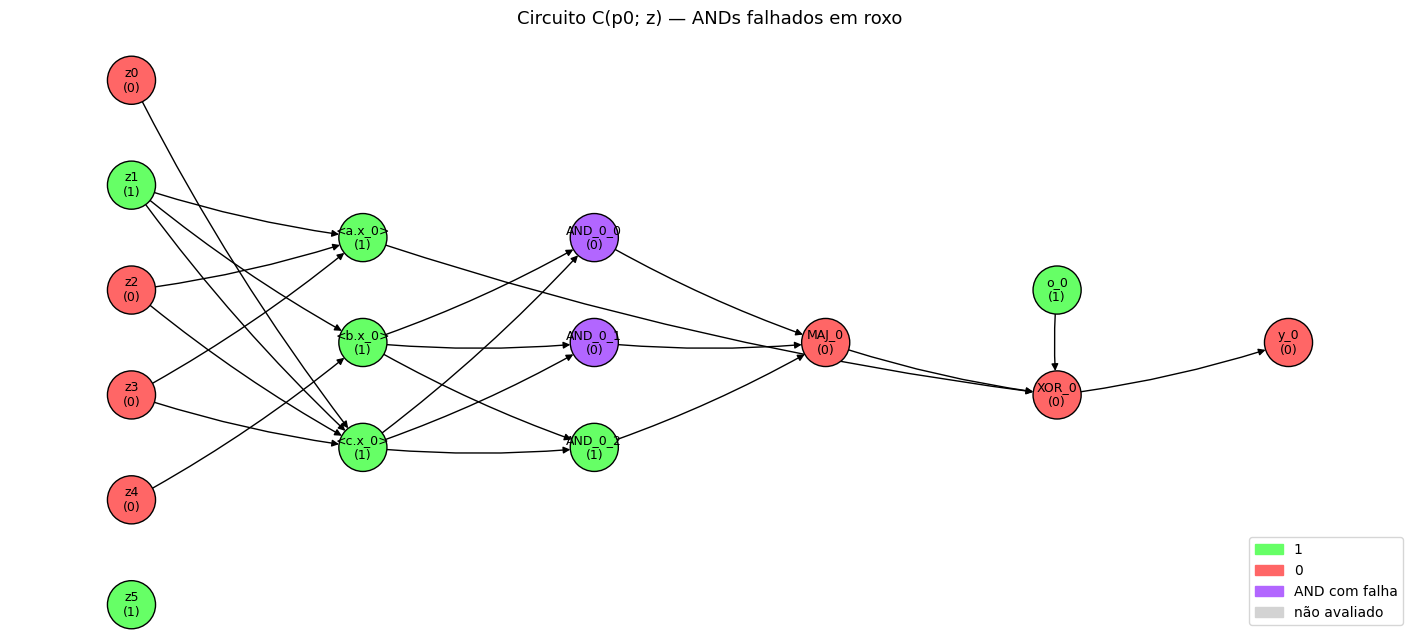


=== Circuito 0 ===
a.x = 1, b.x = 1, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [1 1 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


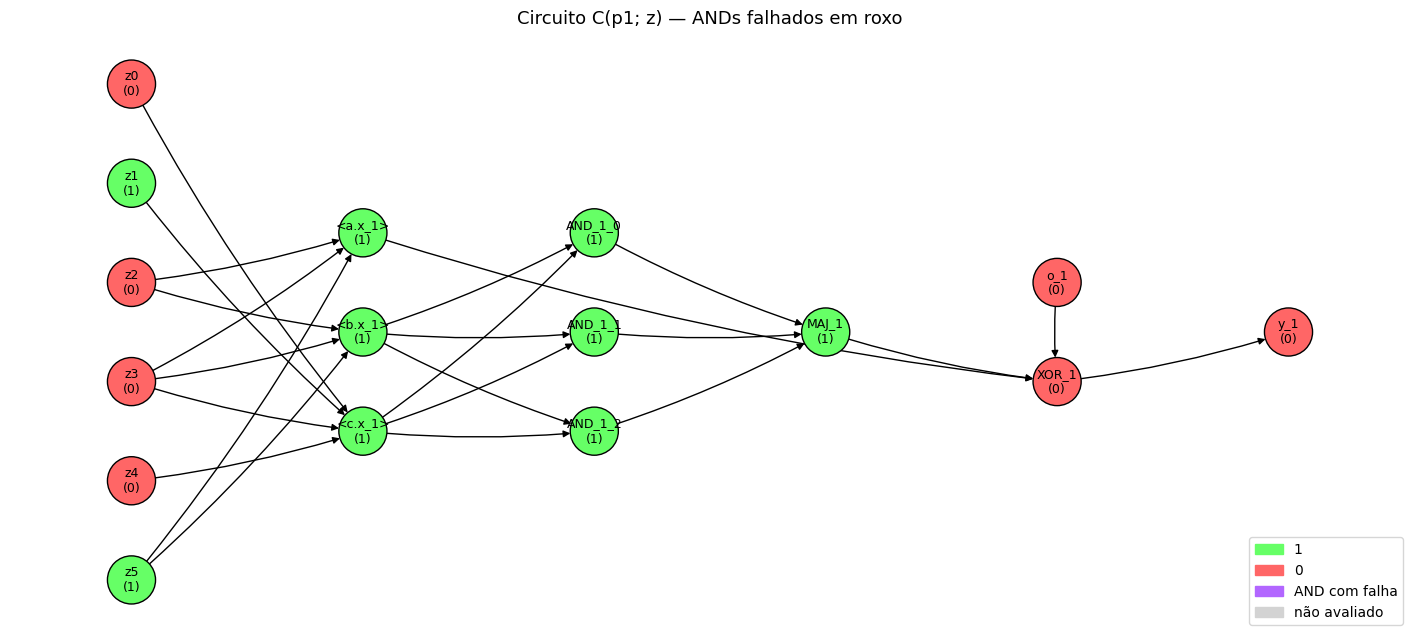


=== Circuito 1 ===
a.x = 1, b.x = 1, c.x = 1
ANDs = [1, 1, 1]
Falhas (f) = [0 0 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


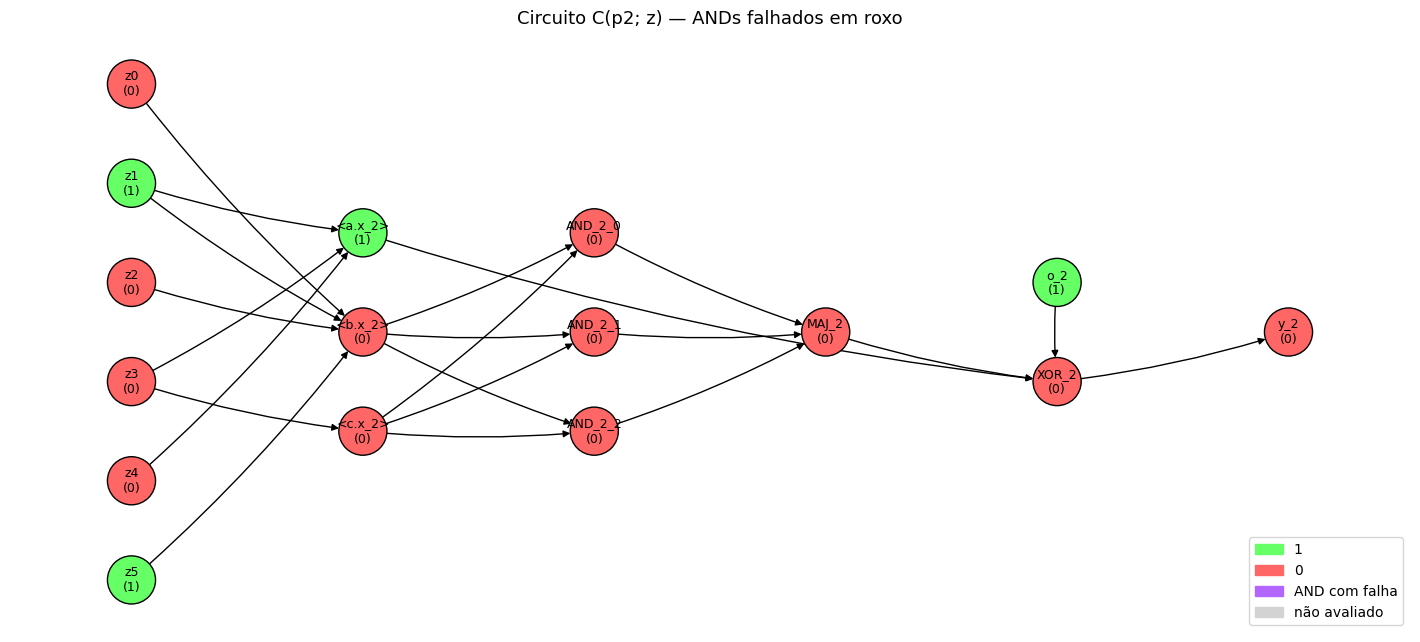


=== Circuito 2 ===
a.x = 1, b.x = 0, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


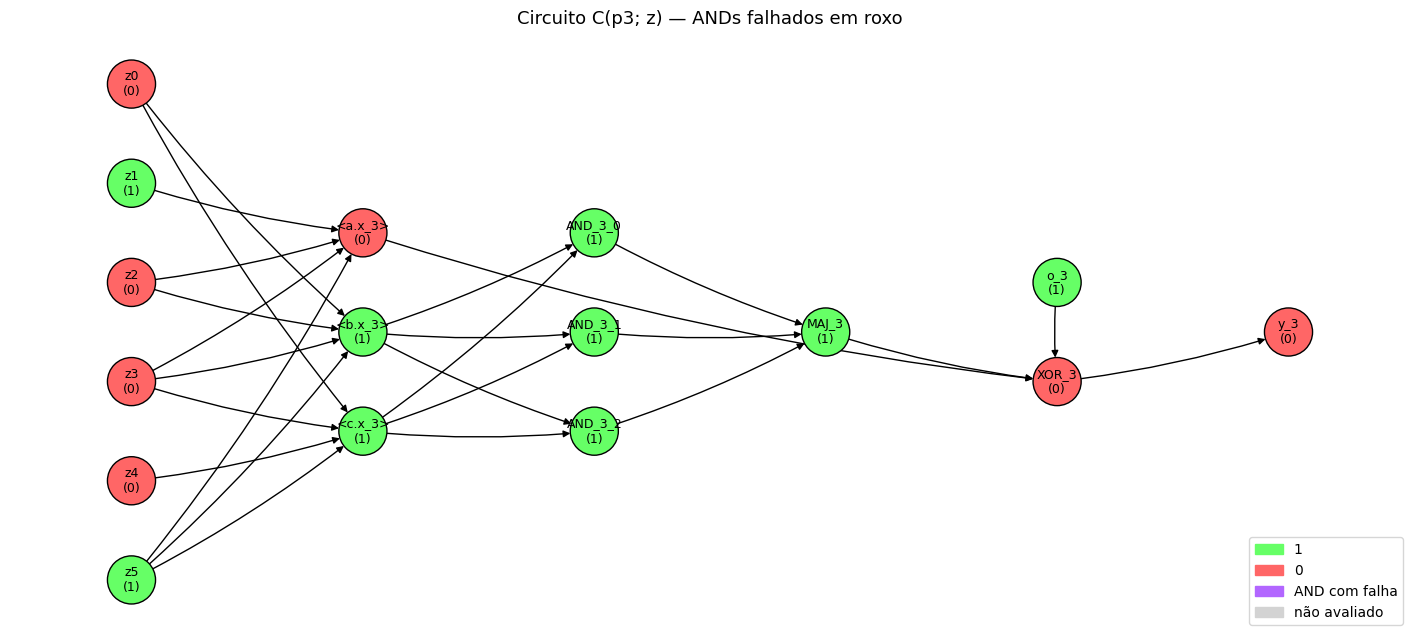


=== Circuito 3 ===
a.x = 0, b.x = 1, c.x = 1
ANDs = [1, 1, 1]
Falhas (f) = [0 0 0]
MAJ = 1, o = 1, XOR = 0, saída y = 0


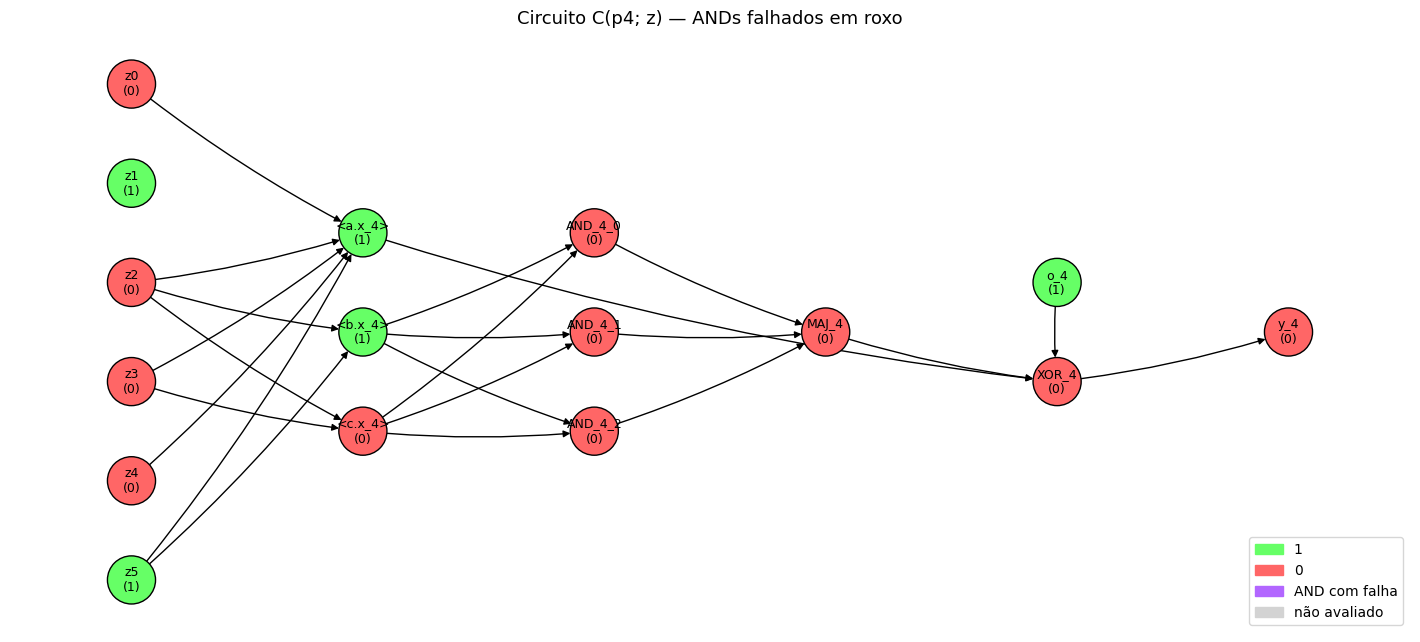


=== Circuito 4 ===
a.x = 1, b.x = 1, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


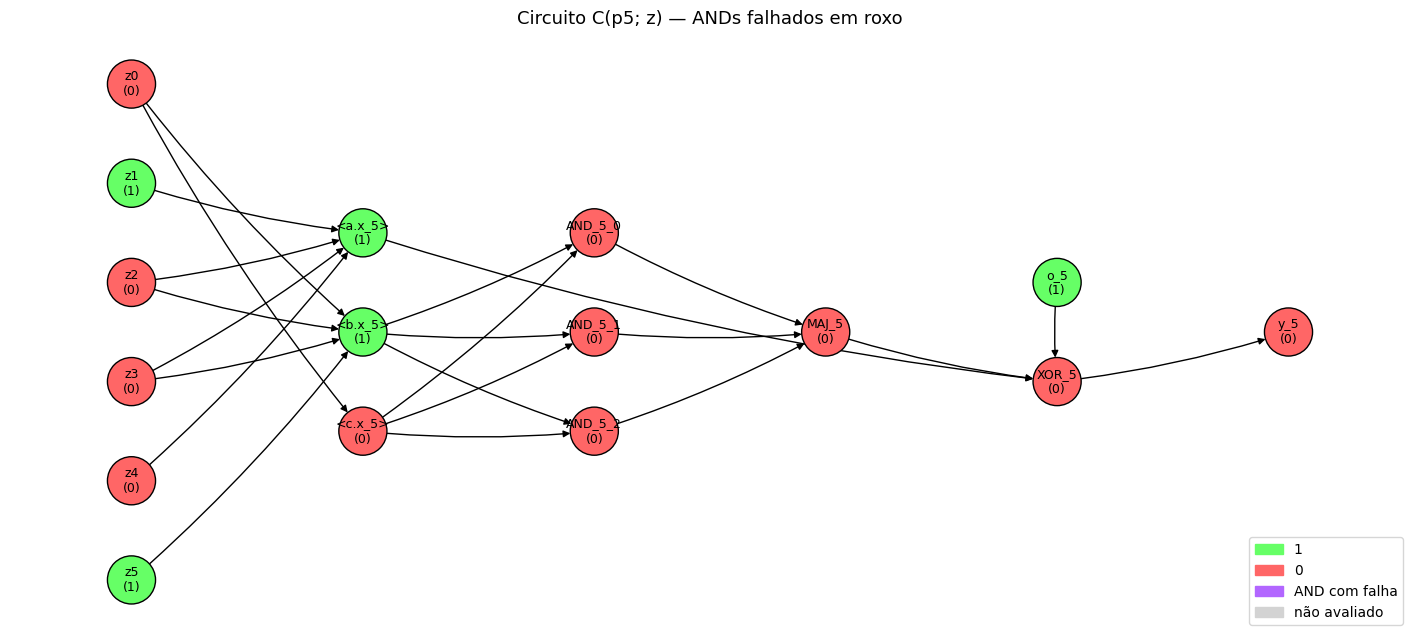


=== Circuito 5 ===
a.x = 1, b.x = 1, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


In [15]:
solver = Solver()
solver.add_assertion(And(constraints))

if solver.solve():
    model = solver.get_model()

    # Reconstruir z_vars do modelo
    z_solution_bits = np.array([1 if model.get_value(z_vars[i]).is_true() else 0 for i in range(n)], dtype=np.uint8)
    z_solution_packed = bits_to_bytes(z_solution_bits)

    # Mostrar z reconstruído
    print("z reconstruído (bits):", z_solution_bits)
    print("z reconstruído (bytes):", z_solution_packed)

    # Reconstruir f_vars do modelo (todos os f_vars[i][j])
    f_solution_bits = []
    for i in range(m):
        f_bits_i = np.array([1 if model.get_value(f_vars[i][j]).is_true() else 0 for j in range(3)],dtype=np.uint8)
        f_solution_bits.append(f_bits_i)
        print(f"faults do solver para f_vars[{i}] (bits):", f_bits_i)

    # Reconstruir a saída o_list usando os faults
    o_list_from_p = [eval_f_numeric(p_list[i], z_solution_bits, f_vars[i]) for i in range(m)]
    print("o_list a partir p_list com faults no AND:", o_list_from_p) #coincide com f_list, debug

    # Plotar circuito
    for i in range(m):
        plot_circuit(p_list[i], i, z_solution_bits, f_solution_bits)  # ajustar índice se precisar

else:
    print("Nenhuma solução encontrada")

solver.exit()

## Modelação final

Podemos assim criar uma função chamada `solverCircuit` que, dados *inputs* $n,m,k,\varepsilon$, gera um segredo $z$ e um polinómio de forma aleatória e tenta recontruir $z$ a partir do modelo que definimos anteriormente. Permitindo assim escalar o problema.

In [16]:
def solverCircuit(n,m,k,eps):
    # Gerar seed s
    s_bits = np.random.randint(0, 2, size=k, dtype=np.uint8)
    s_packed = bits_to_bytes(s_bits)

    print("Seed (bits):", s_bits)
    print("Seed (bytes):", s_packed)

    # Usar a seed compactada para inicializar RNG
    rng = np.random.RandomState(s_packed)  

    a_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
    b_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
    c_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)

    # Segredo z
    z_bits = make_polynom(n, rng)
    z_packed = bits_to_bytes(z_bits)

    print("z (bits) =", z_bits)
    print("z (bytes) =", z_packed)

    p0_list = [(0, a_list[i], b_list[i], c_list[i]) for i in range(m)]
    o_list = [eval_f_numeric(p0_list[i], z_bits, [0,0,0]) for i in range(m)]
    p_list = [(int(o_list[i]), a_list[i], b_list[i], c_list[i]) for i in range(m)]

    # Variáveis booleanas simbólicas
    z_vars = [Symbol(f"z{i}", BOOL) for i in range(n)]
    f_vars = [[Symbol(f"f{i}_{j}", BOOL) for j in range(3)] for i in range(m)]   # simboliza erros no AND

    constraints = []
    # Restrição 1: limitar número de falhas permitido (até epsilon * m)
    max_faults = int(np.floor(eps*m*3))
    fault_terms = [Ite(f_vars[i][j], Int(1), Int(0)) for i in range(m) for j in range(3)]
    constraints.append(LE(Plus(fault_terms), Int(max_faults)))

    # Restrição 2: As restrições lógicas do circuito devem ser respeitadas
    for i in range(m):
        o_param = 0
        ax_symb = sum_1_symb(a_list[i], z_vars)
        bx_symb = sum_1_symb(b_list[i], z_vars)
        cx_symb = sum_1_symb(c_list[i], z_vars)
        
        and_faults = [ Ite(f_vars[i][j], Not(And(bx_symb, cx_symb)), And(bx_symb, cx_symb)) for j in range(3)]
        maj_expr = maj_symb(and_faults[0], and_faults[1], and_faults[2])

        y_expr = xor_n([Bool(bool(o_param)), ax_symb, maj_expr])
        constraints.append(EqualsOrIff(y_expr, Bool(bool(o_list[i]))))


    solver = Solver()
    solver.add_assertion(And(constraints))

    if solver.solve():
        model = solver.get_model()
        z_solution_bits = np.array([1 if model.get_value(z_vars[i]).is_true() else 0 for i in range(n)], dtype=np.uint8)
        z_solution_packed = bits_to_bytes(z_solution_bits)

        print("========================================")
        print("z reconstruído (bits):", z_solution_bits)
        print("z reconstruído (bytes):", z_solution_packed)

        # Reconstruir f_vars do modelo (todos os f_vars[i][j])
        f_solution_bits = []
        for i in range(m):
            f_bits_i = np.array([1 if model.get_value(f_vars[i][j]).is_true() else 0 for j in range(3)],dtype=np.uint8)
            f_solution_bits.append(f_bits_i)
            print(f"faults do solver para f_vars[{i}] (bits):", f_bits_i)

        # Reconstruir a saída o_list usando os faults
        o_list_from_p = [eval_f_numeric(p_list[i], z_solution_bits, f_vars[i]) for i in range(m)]
        print("o_list a partir p_list com faults no AND:", o_list_from_p) #coincide com f_list, debug

        # Plotar circuito
        for i in range(m):
            plot_circuit(p_list[i], i, z_solution_bits, f_solution_bits)  # ajustar índice se precisar
        else:
            print("Nenhuma solução encontrada.")

    solver.exit()

### Testes

Seed (bits): [0 1 1 0 1 0 1 1]
Seed (bytes): [107]
z (bits) = [0 0 0 0 0 0 0 1]
z (bytes) = [1]
z reconstruído (bits): [0 1 1 0 1 1 0 0]
z reconstruído (bytes): [108]
faults do solver para f_vars[0] (bits): [1 1 0]
faults do solver para f_vars[1] (bits): [0 0 0]
faults do solver para f_vars[2] (bits): [0 0 0]
faults do solver para f_vars[3] (bits): [1 1 0]
o_list a partir p_list com faults no AND: [0, 1, 1, 0]


/tmp/ipykernel_85794/3150101287.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


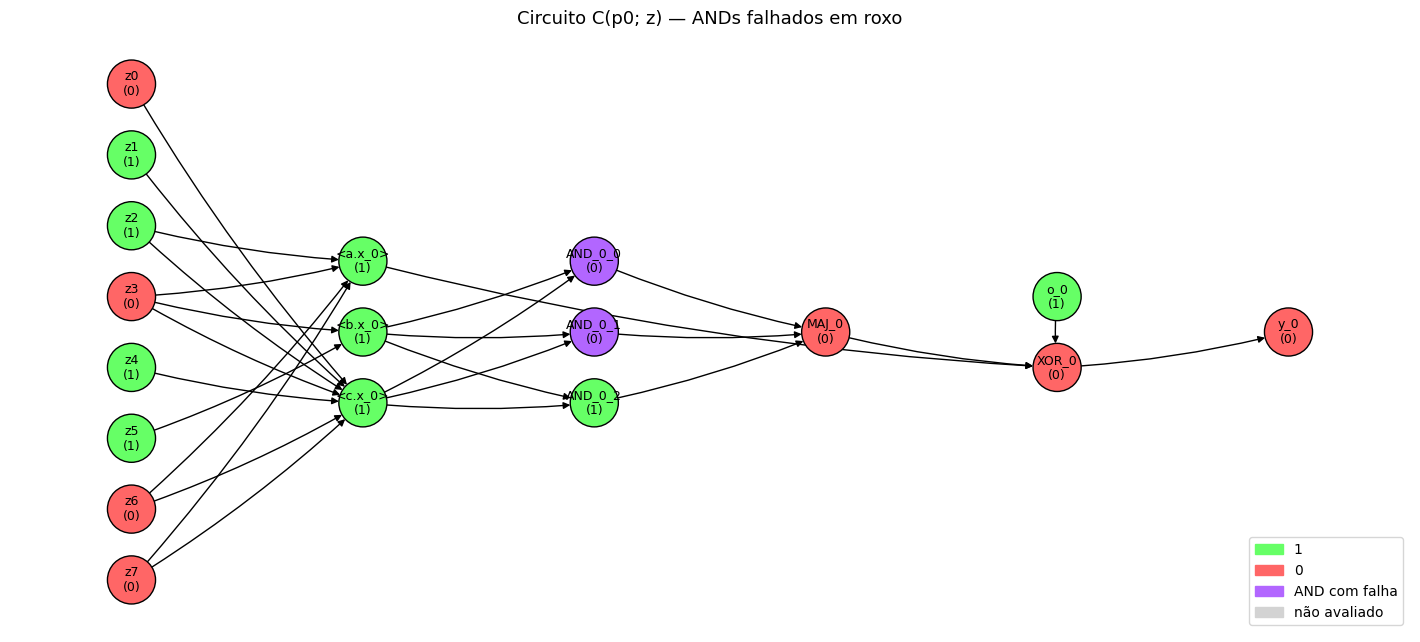


=== Circuito 0 ===
a.x = 1, b.x = 1, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [1 1 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


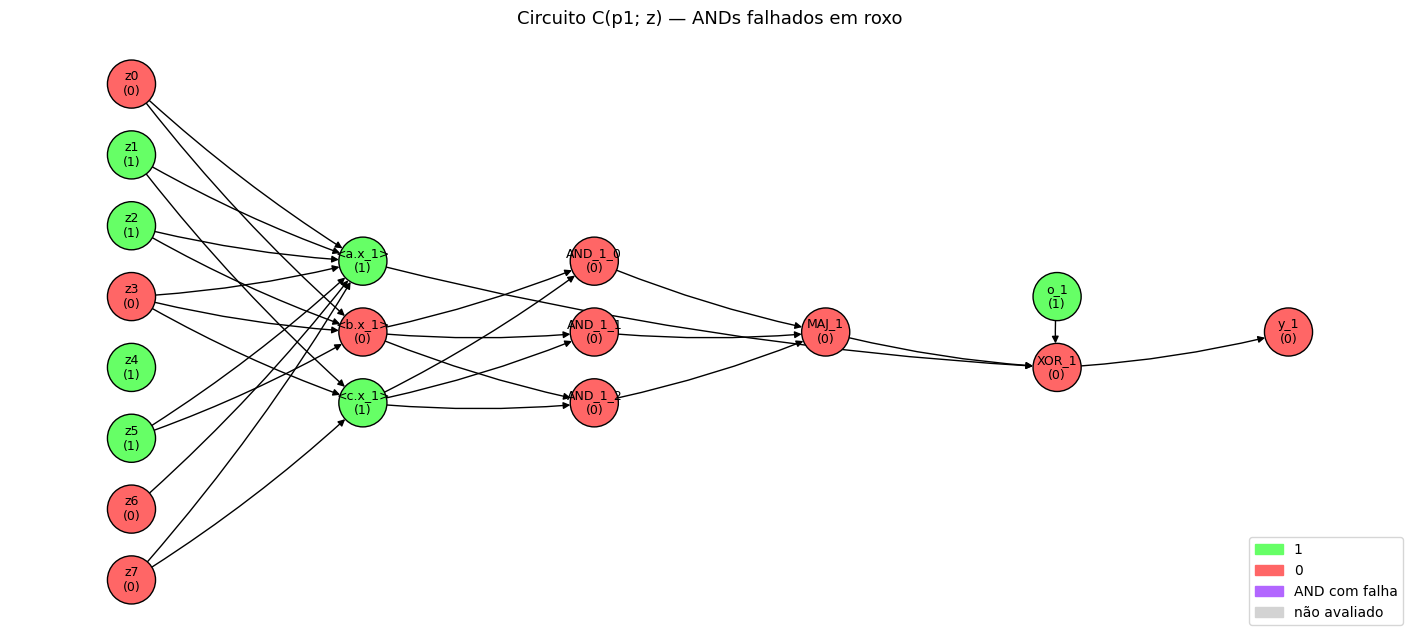


=== Circuito 1 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


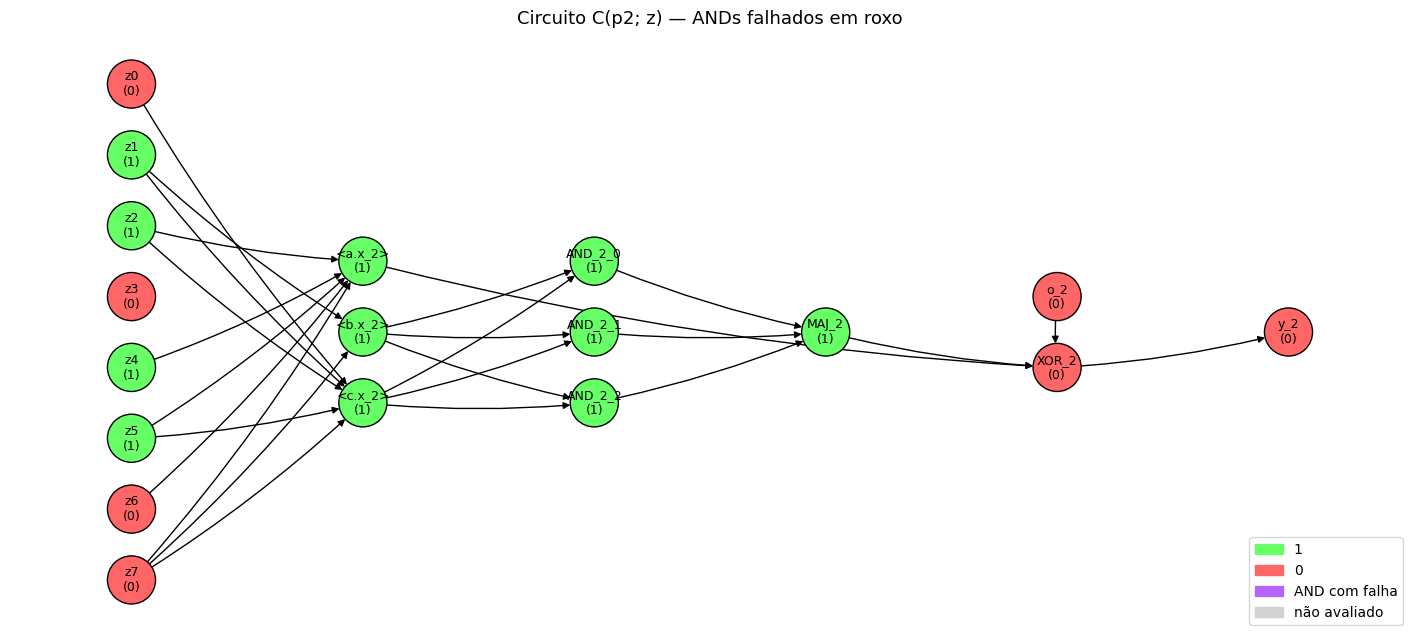


=== Circuito 2 ===
a.x = 1, b.x = 1, c.x = 1
ANDs = [1, 1, 1]
Falhas (f) = [0 0 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


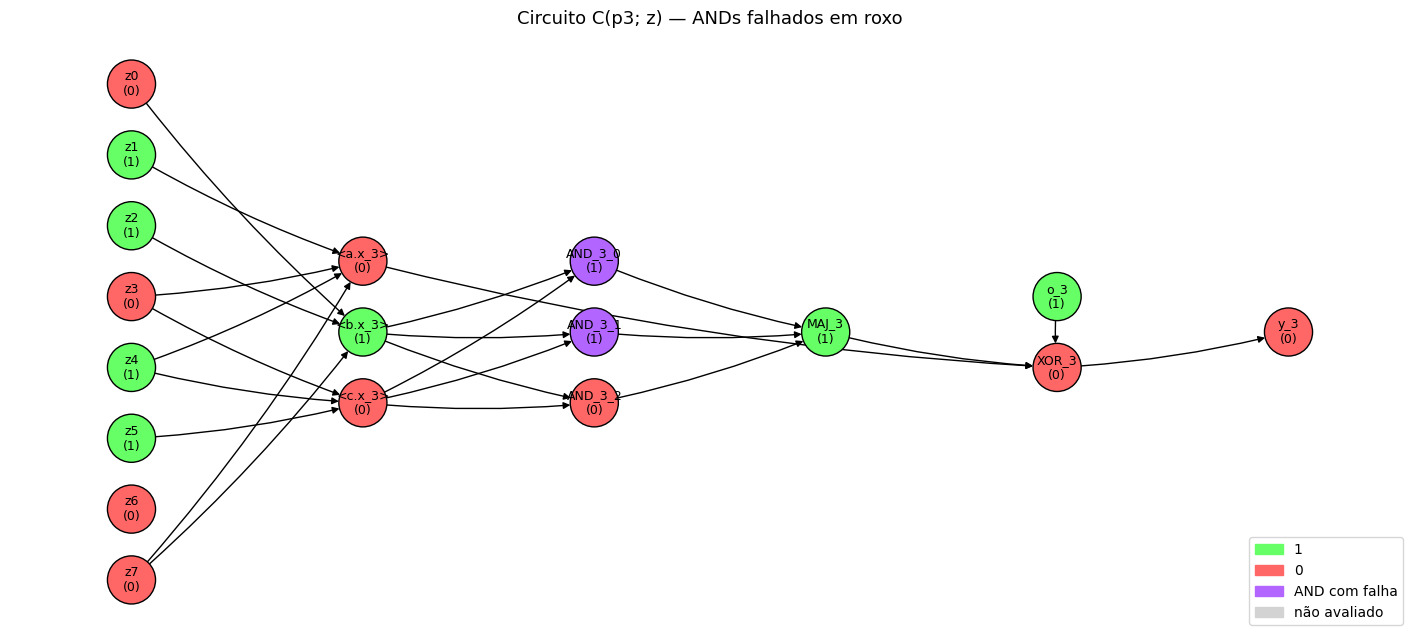


=== Circuito 3 ===
a.x = 0, b.x = 1, c.x = 0
ANDs = [1, 1, 0]
Falhas (f) = [1 1 0]
MAJ = 1, o = 1, XOR = 0, saída y = 0
Nenhuma solução encontrada.


In [17]:
# Test 1:
solverCircuit(8,4,8,1)

Seed (bits): [0 1 0 0 0 1 1]
Seed (bytes): [70]
z (bits) = [0 1 0 0 0 1 0 1 0 1 1 1 0]
z (bytes) = [ 69 112]
z reconstruído (bits): [1 1 0 0 0 1 0 0 0 0 0 0 0]
z reconstruído (bytes): [196   0]
faults do solver para f_vars[0] (bits): [0 0 0]
faults do solver para f_vars[1] (bits): [0 0 0]
faults do solver para f_vars[2] (bits): [0 0 0]
faults do solver para f_vars[3] (bits): [0 0 0]
faults do solver para f_vars[4] (bits): [1 1 0]
faults do solver para f_vars[5] (bits): [1 1 0]
faults do solver para f_vars[6] (bits): [1 1 0]
faults do solver para f_vars[7] (bits): [0 0 0]
faults do solver para f_vars[8] (bits): [1 1 0]
faults do solver para f_vars[9] (bits): [0 0 0]
faults do solver para f_vars[10] (bits): [0 0 0]
faults do solver para f_vars[11] (bits): [1 1 0]
faults do solver para f_vars[12] (bits): [0 0 0]
o_list a partir p_list com faults no AND: [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]


/tmp/ipykernel_85794/3150101287.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


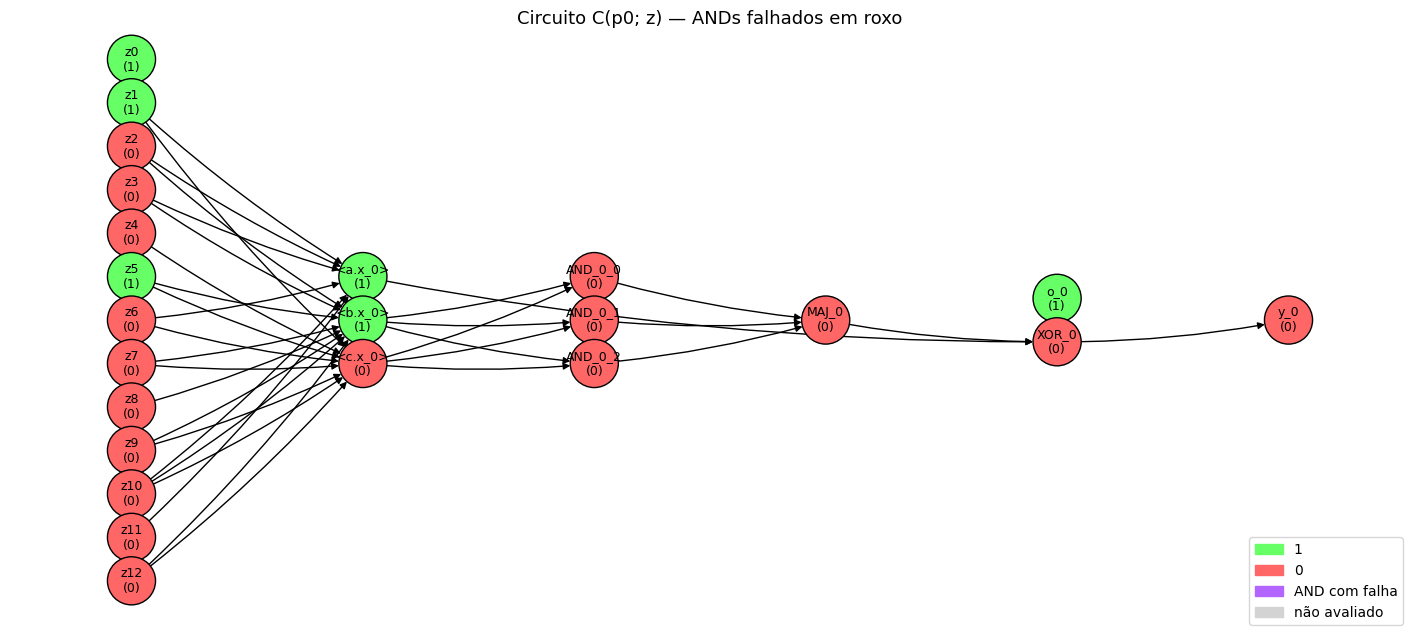


=== Circuito 0 ===
a.x = 1, b.x = 1, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


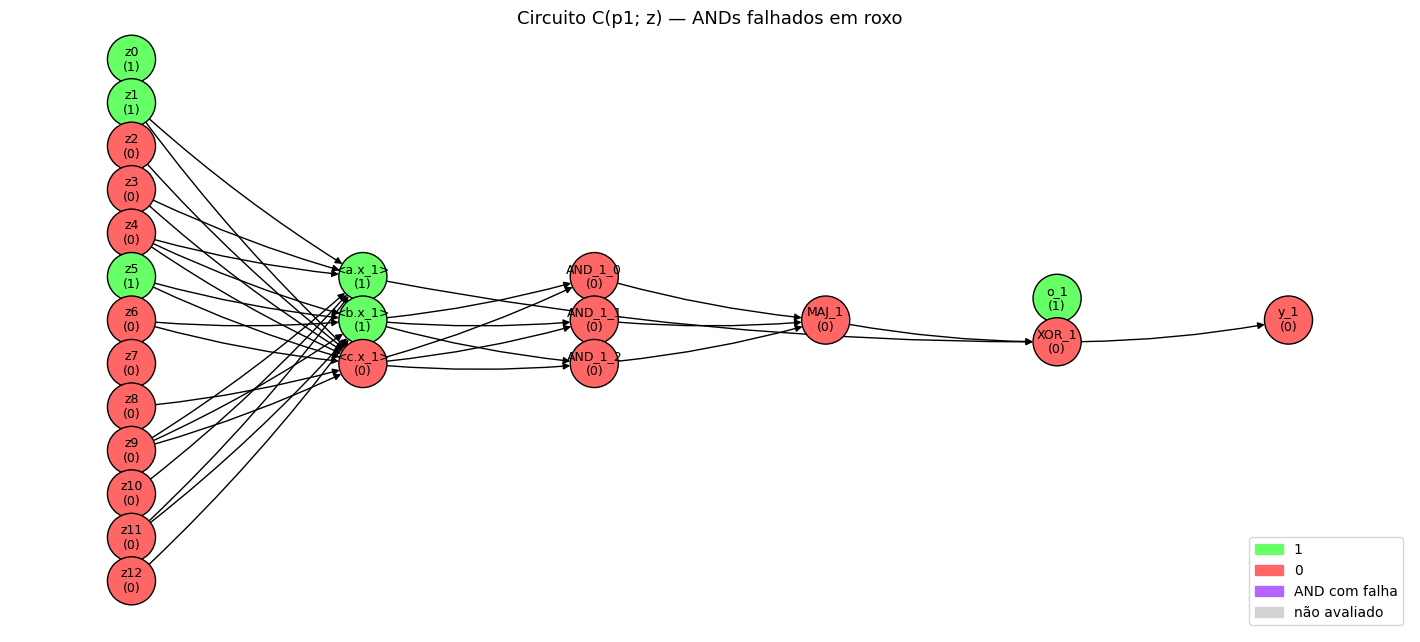


=== Circuito 1 ===
a.x = 1, b.x = 1, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


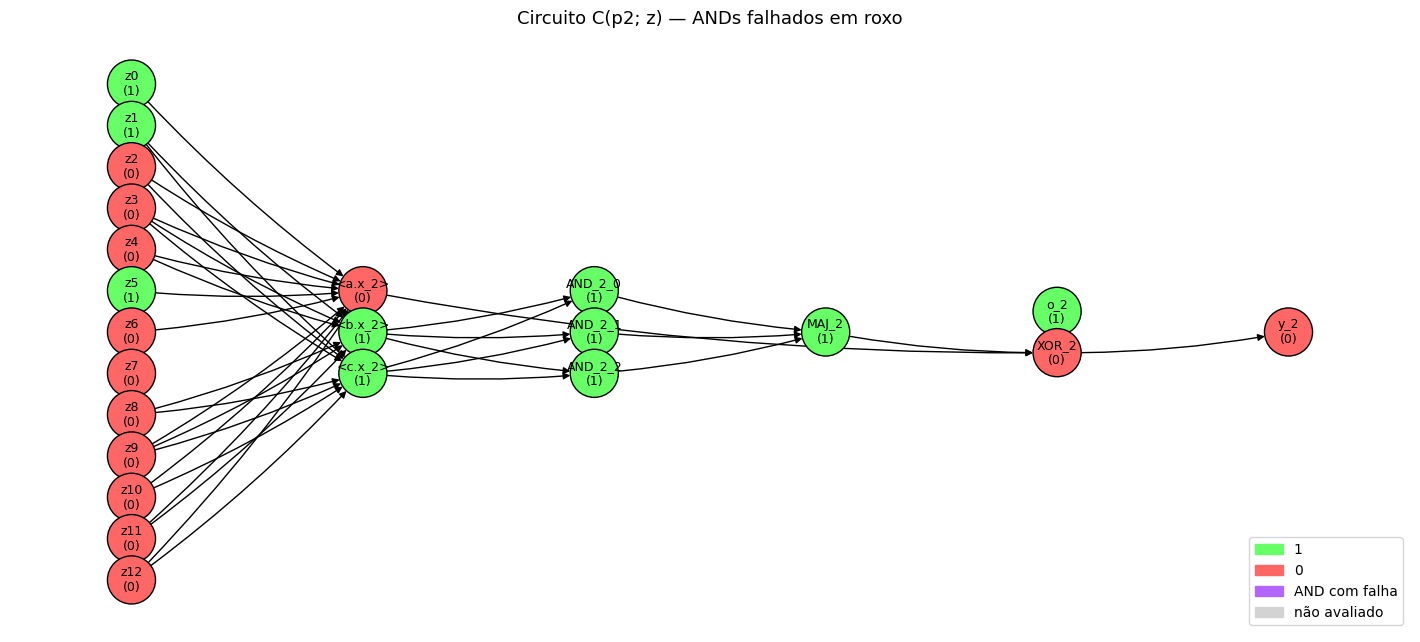


=== Circuito 2 ===
a.x = 0, b.x = 1, c.x = 1
ANDs = [1, 1, 1]
Falhas (f) = [0 0 0]
MAJ = 1, o = 1, XOR = 0, saída y = 0


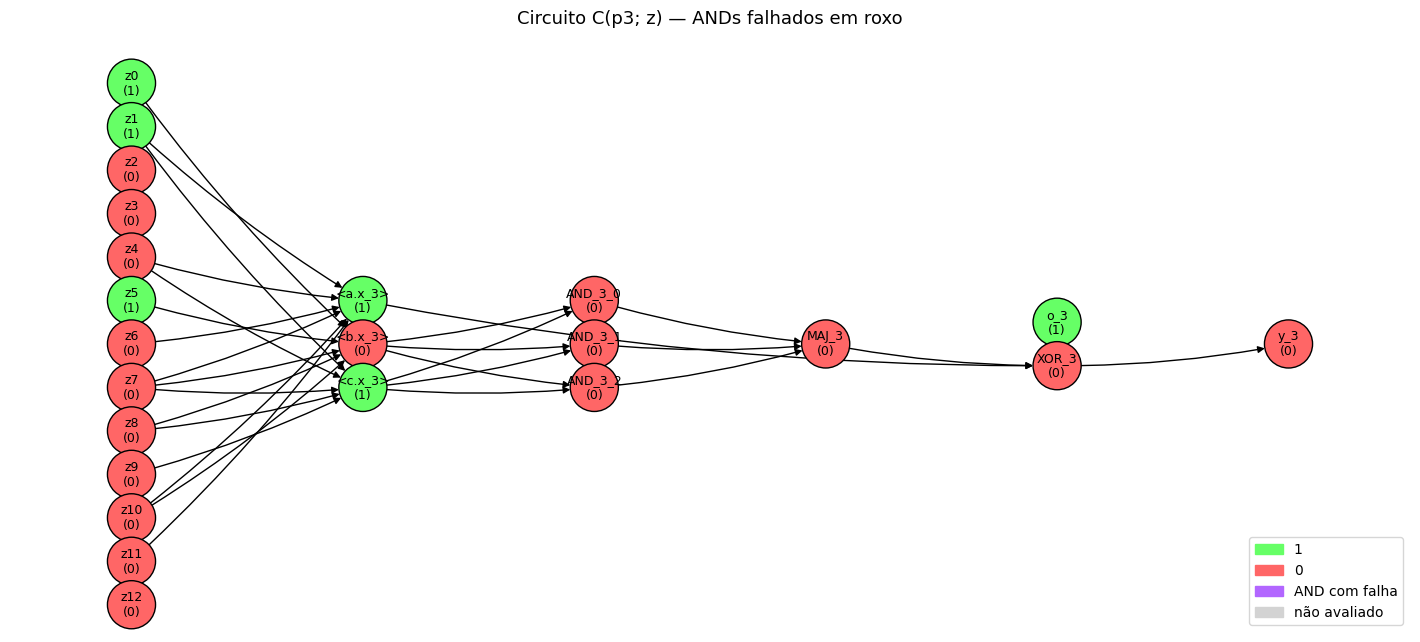


=== Circuito 3 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


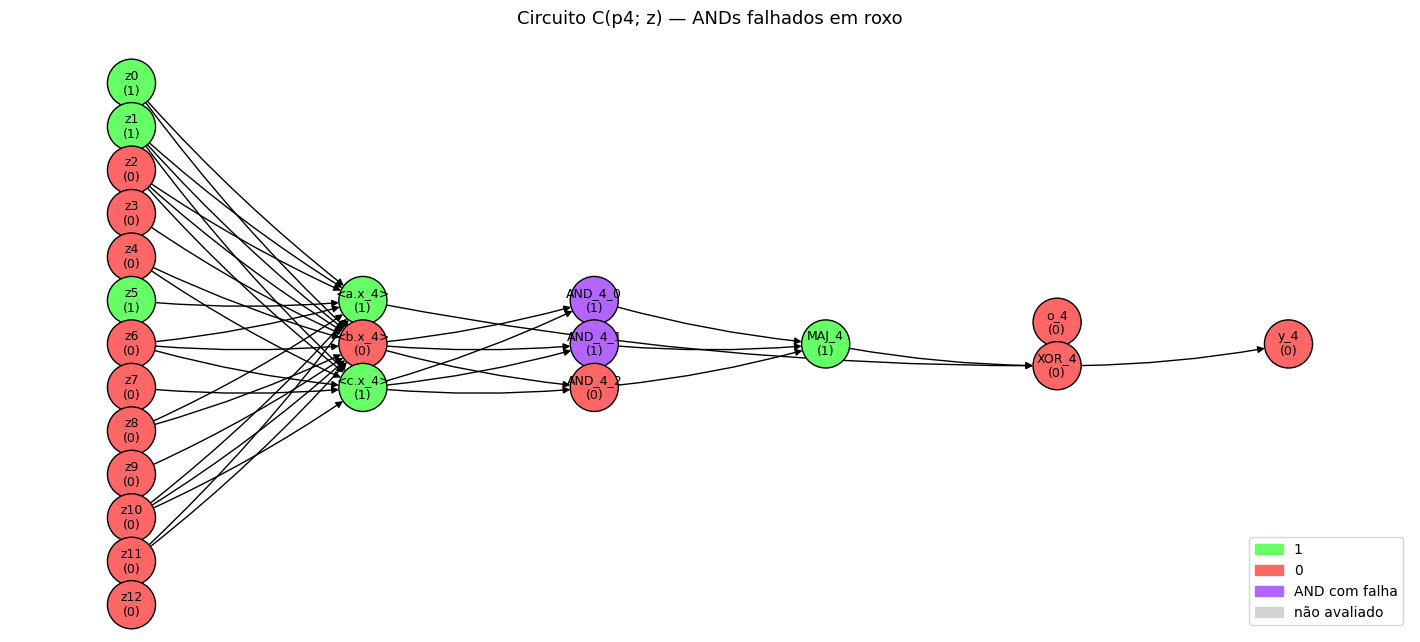


=== Circuito 4 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [1, 1, 0]
Falhas (f) = [1 1 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


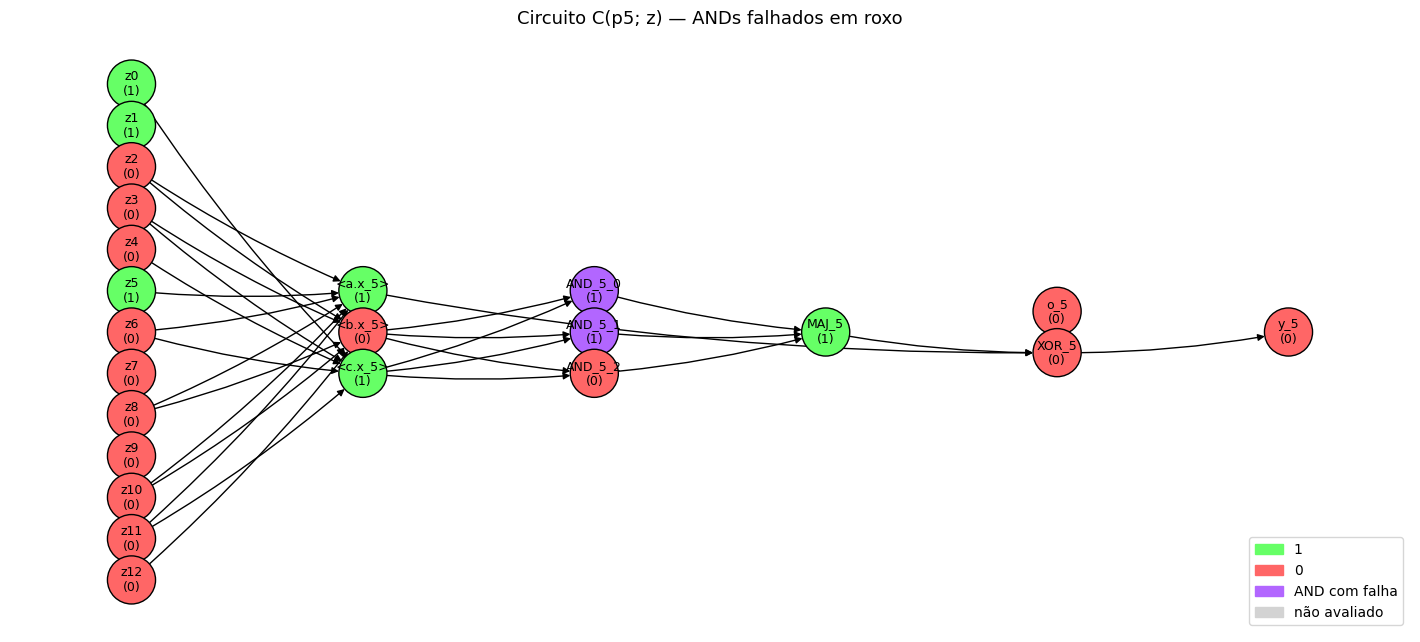


=== Circuito 5 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [1, 1, 0]
Falhas (f) = [1 1 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


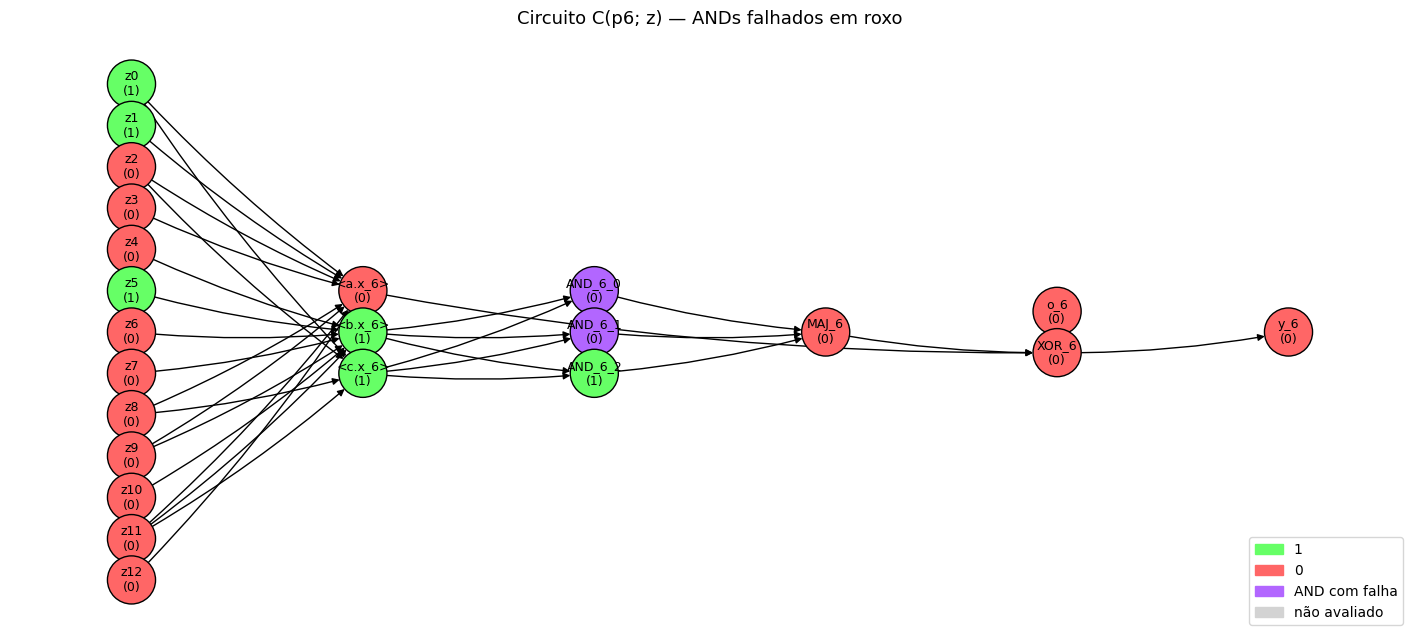


=== Circuito 6 ===
a.x = 0, b.x = 1, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [1 1 0]
MAJ = 0, o = 0, XOR = 0, saída y = 0


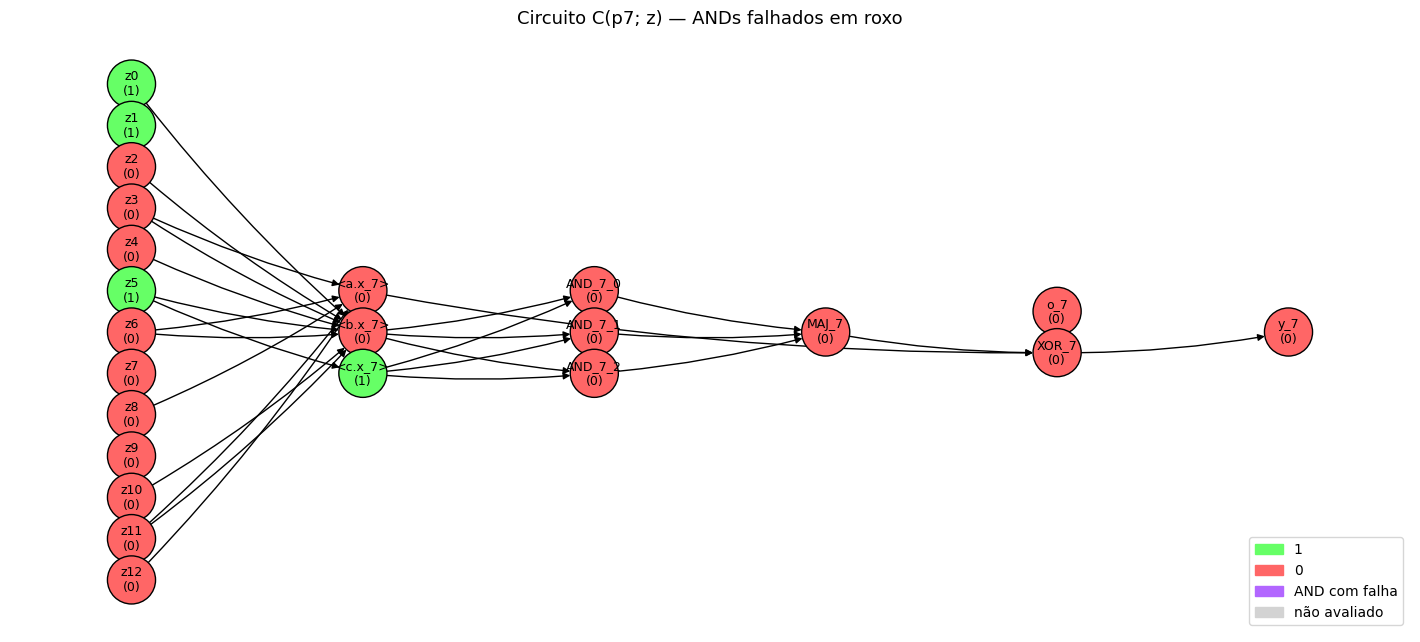


=== Circuito 7 ===
a.x = 0, b.x = 0, c.x = 1
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 0, XOR = 0, saída y = 0


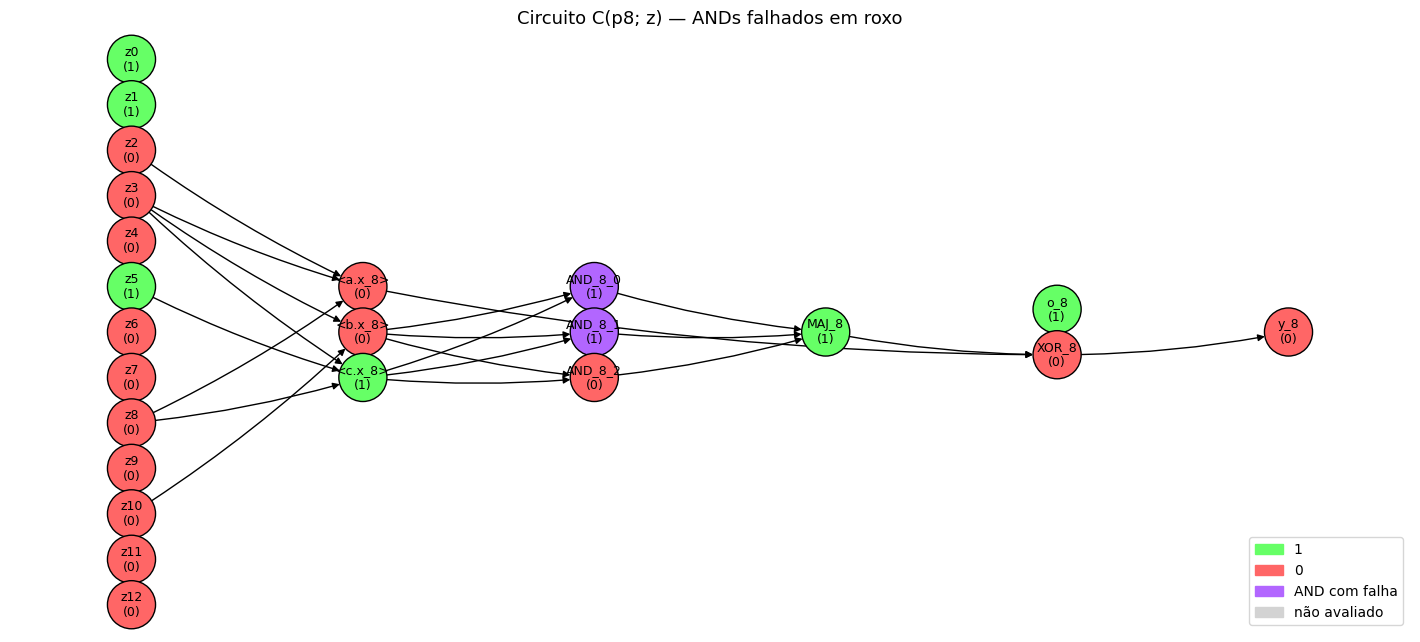


=== Circuito 8 ===
a.x = 0, b.x = 0, c.x = 1
ANDs = [1, 1, 0]
Falhas (f) = [1 1 0]
MAJ = 1, o = 1, XOR = 0, saída y = 0


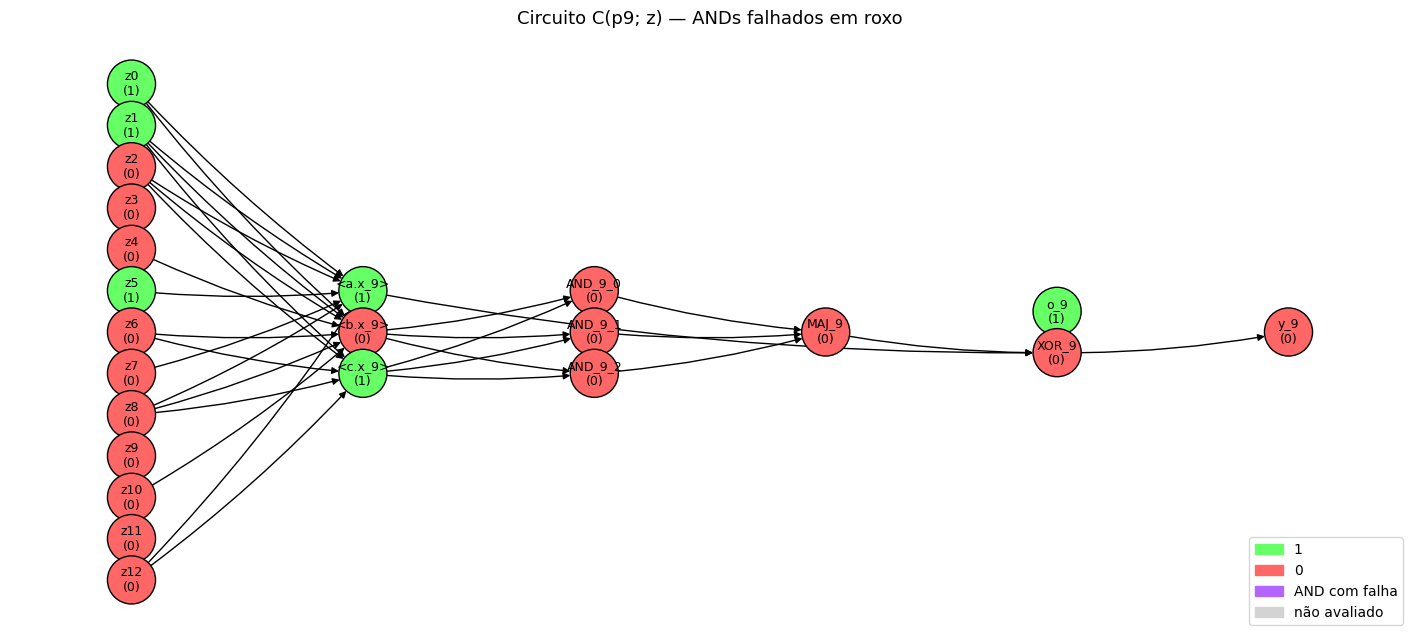


=== Circuito 9 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0


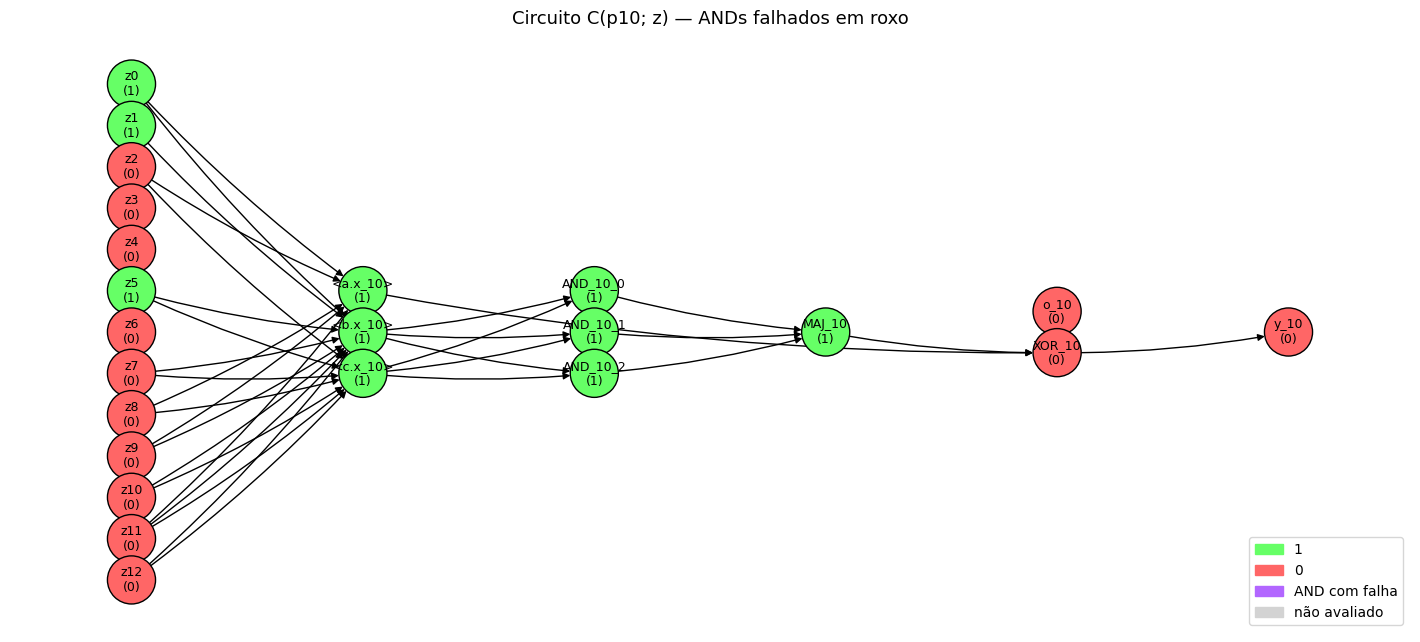


=== Circuito 10 ===
a.x = 1, b.x = 1, c.x = 1
ANDs = [1, 1, 1]
Falhas (f) = [0 0 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


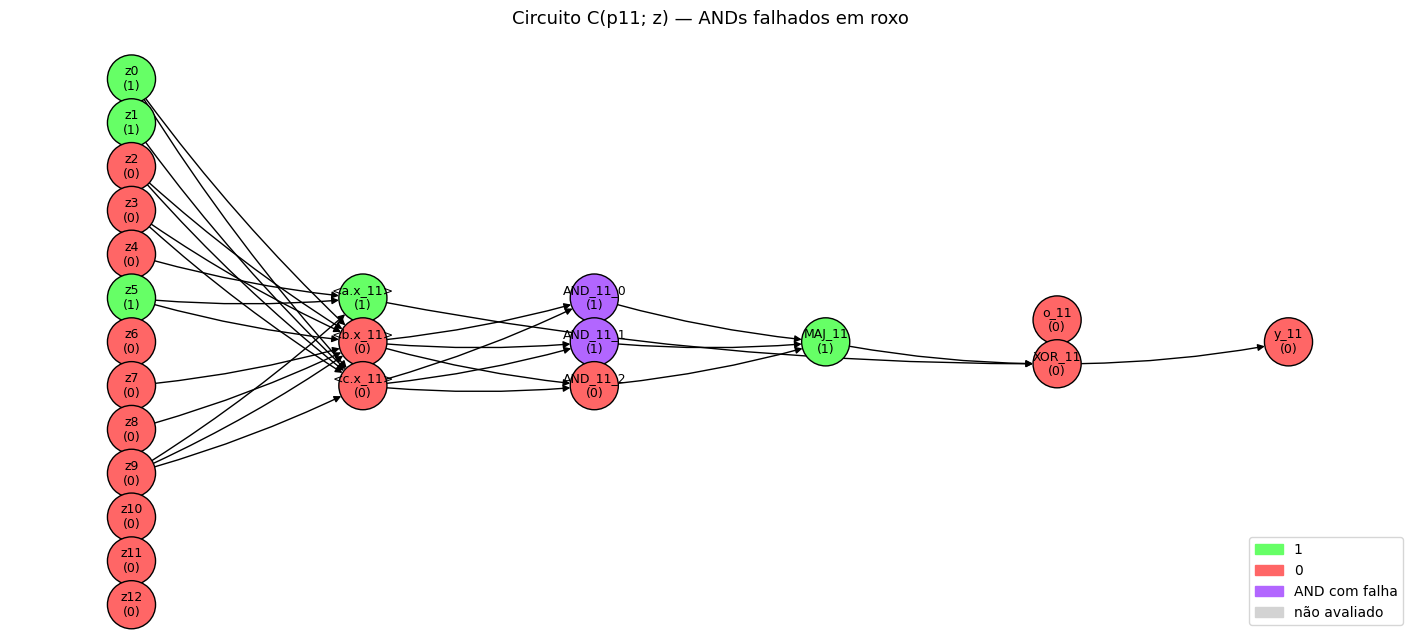


=== Circuito 11 ===
a.x = 1, b.x = 0, c.x = 0
ANDs = [1, 1, 0]
Falhas (f) = [1 1 0]
MAJ = 1, o = 0, XOR = 0, saída y = 0


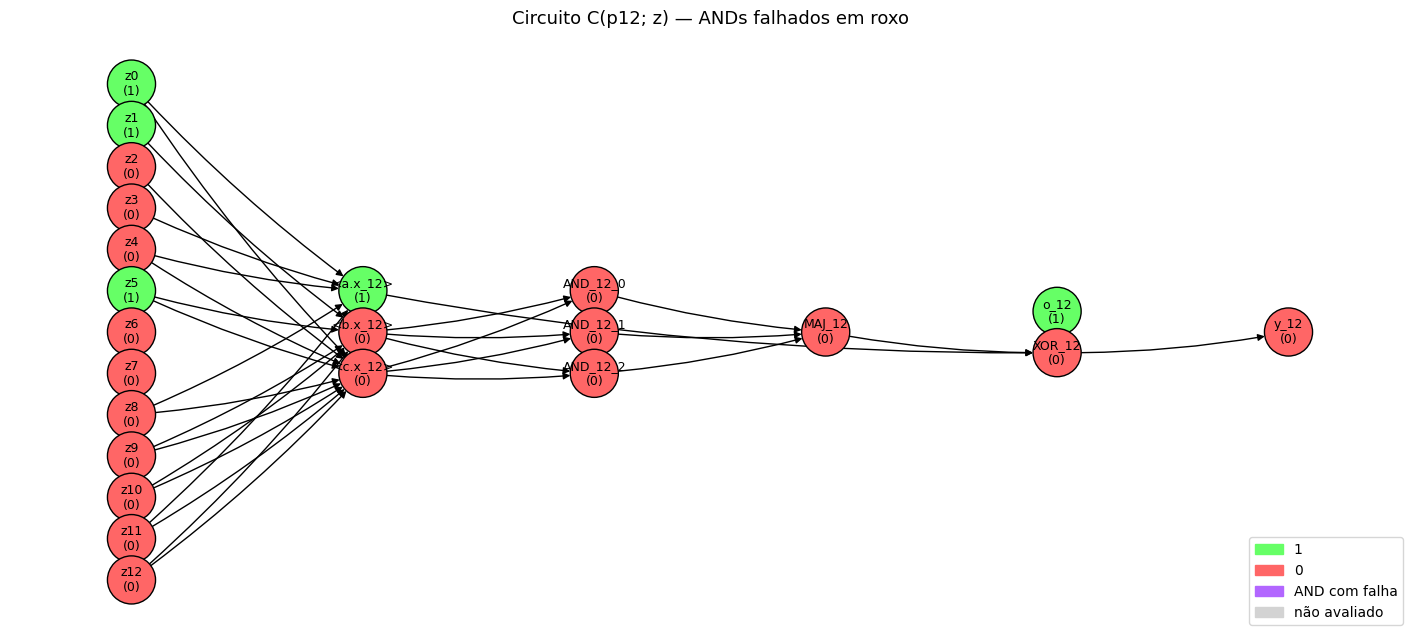


=== Circuito 12 ===
a.x = 1, b.x = 0, c.x = 0
ANDs = [0, 0, 0]
Falhas (f) = [0 0 0]
MAJ = 0, o = 1, XOR = 0, saída y = 0
Nenhuma solução encontrada.


In [18]:
# Test 2:
solverCircuit(13,13,7,1)

### Maximinazar a probabilidade de falhas

Queremos agora, a partir de um $z\in\{0,1\}^n$, maximizar a probabilidade de falhas and sem que o *output* $0^n$ seja alterado.

Vamos seguir as seguintes etapas:

1. Gera-se um segredo $z$ e um polinómio $p$ de forma aleatória em que $o = 0^m$.
2. Calcula-se a chave pública, mais especificamente a lista $o$.
3. Cria-se as variáveis de decisão $z'_i$ e $f_{i,j}$ tal que $z'_i = z_i$. Queremos maximizar o somatório em $f_{i,j}$.
4. Vamos utilizar *binary search* para procurar o maior número de falhas possível, uma vez que a propriedade "existir solução para k falhas" é **monotónica**.








Seed (bits): [1 1 1 0 1 0 0 0]
Seed (bytes): [232]
z (bits) = [1 1 0 0 0 1]
z (bytes) = [196]
Máximo número de falhas toleradas: 6 / 18
Probabilidade máxima de falha tolerada: 0.3333
z reconstruído (bits): [1 1 0 0 0 1]
faults do solver para f_vars[0] (bits): [1 0 0]
faults do solver para f_vars[1] (bits): [0 0 1]
faults do solver para f_vars[2] (bits): [0 0 1]
faults do solver para f_vars[3] (bits): [0 0 1]
faults do solver para f_vars[4] (bits): [0 0 1]
faults do solver para f_vars[5] (bits): [1 0 0]
o_list a partir p_list com faults no AND: [0, 0, 0, 0, 0, 0]


/tmp/ipykernel_85794/3150101287.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


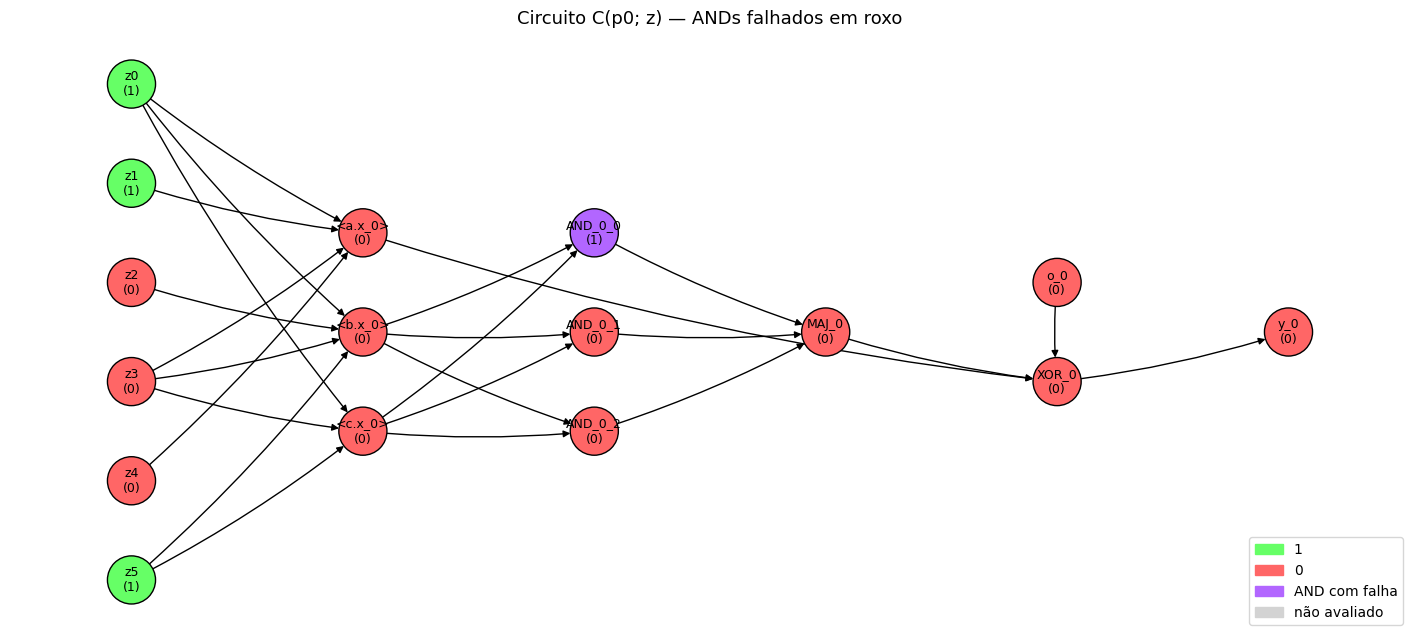


=== Circuito 0 ===
a.x = 0, b.x = 0, c.x = 0
ANDs = [1, 0, 0]
Falhas (f) = [1 0 0]
MAJ = 0, o = 0, XOR = 0, saída y = 0


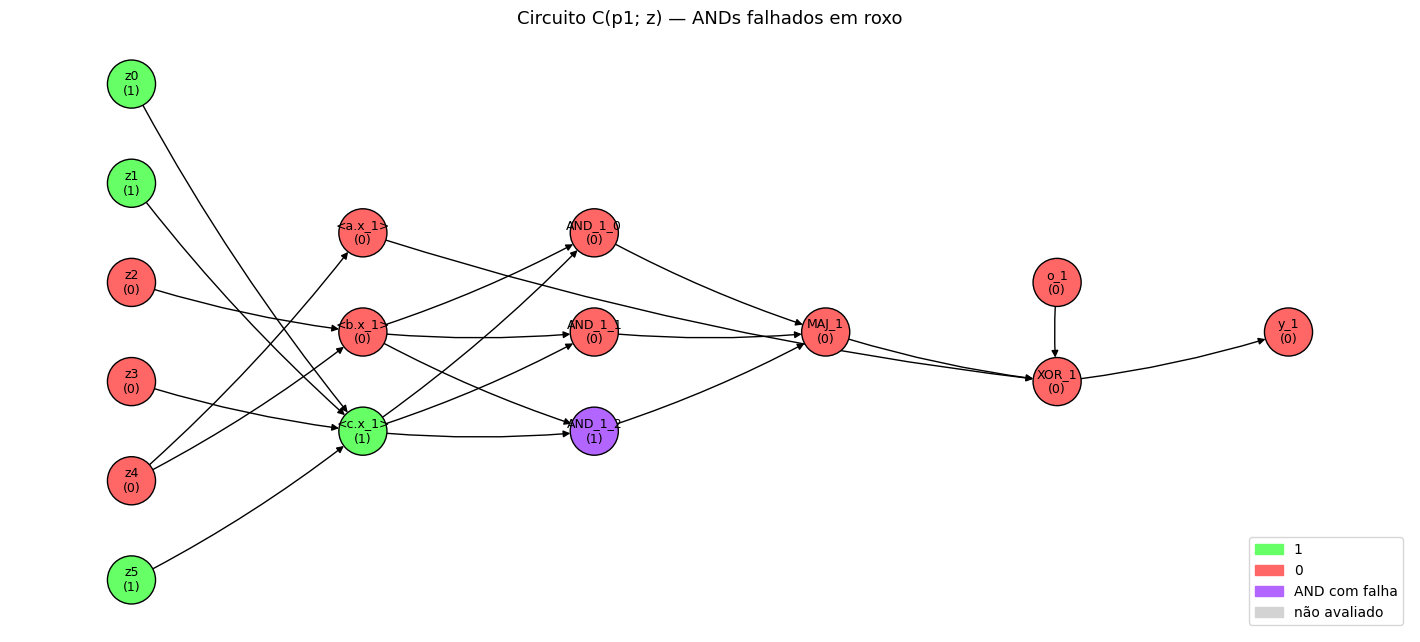


=== Circuito 1 ===
a.x = 0, b.x = 0, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [0 0 1]
MAJ = 0, o = 0, XOR = 0, saída y = 0


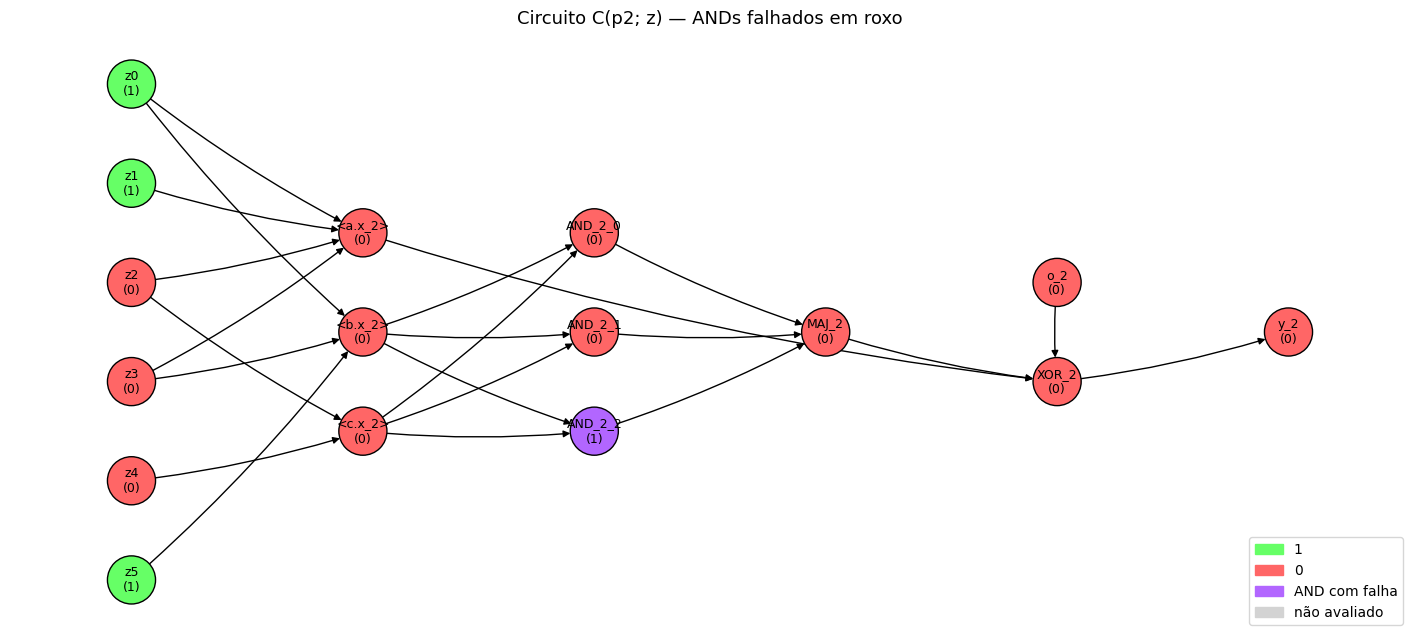


=== Circuito 2 ===
a.x = 0, b.x = 0, c.x = 0
ANDs = [0, 0, 1]
Falhas (f) = [0 0 1]
MAJ = 0, o = 0, XOR = 0, saída y = 0


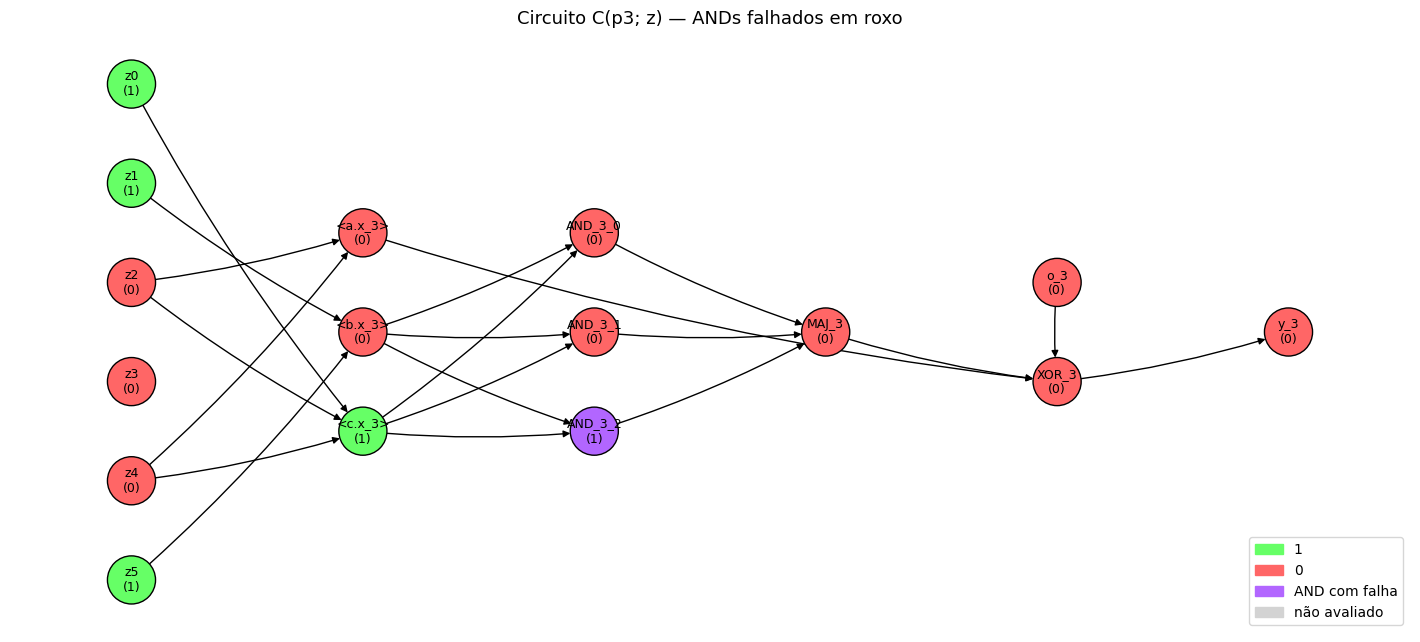


=== Circuito 3 ===
a.x = 0, b.x = 0, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [0 0 1]
MAJ = 0, o = 0, XOR = 0, saída y = 0


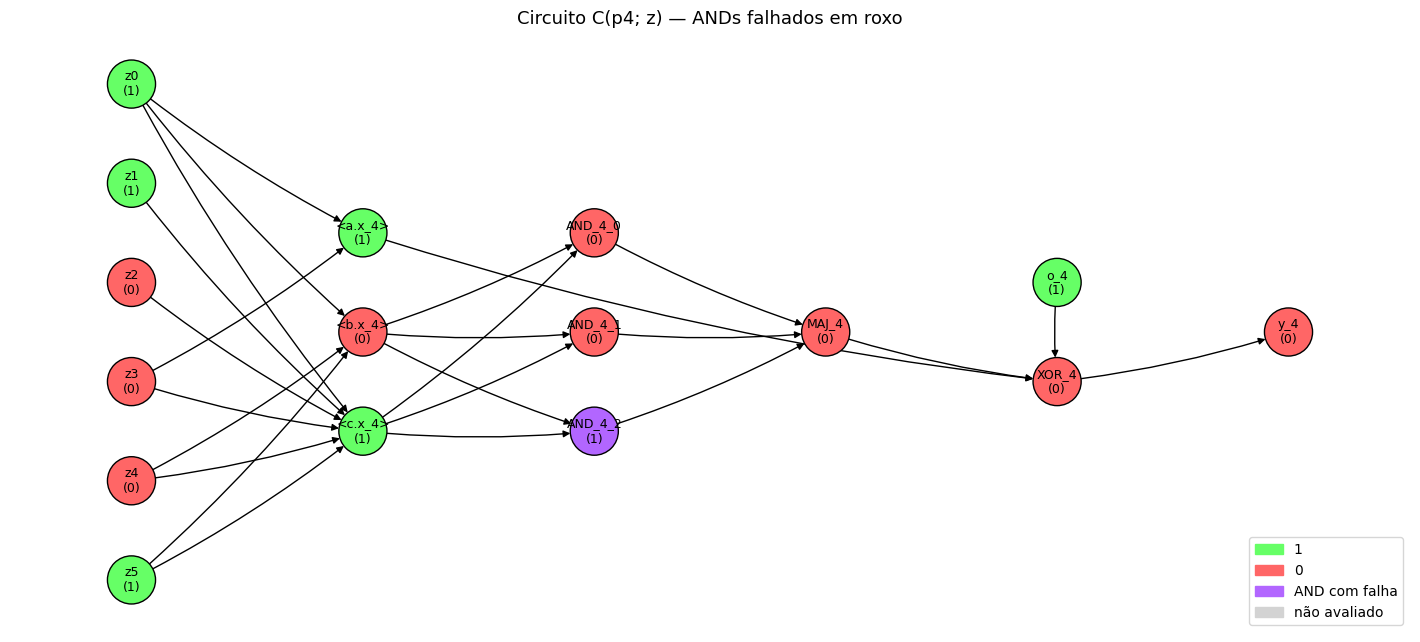


=== Circuito 4 ===
a.x = 1, b.x = 0, c.x = 1
ANDs = [0, 0, 1]
Falhas (f) = [0 0 1]
MAJ = 0, o = 1, XOR = 0, saída y = 0


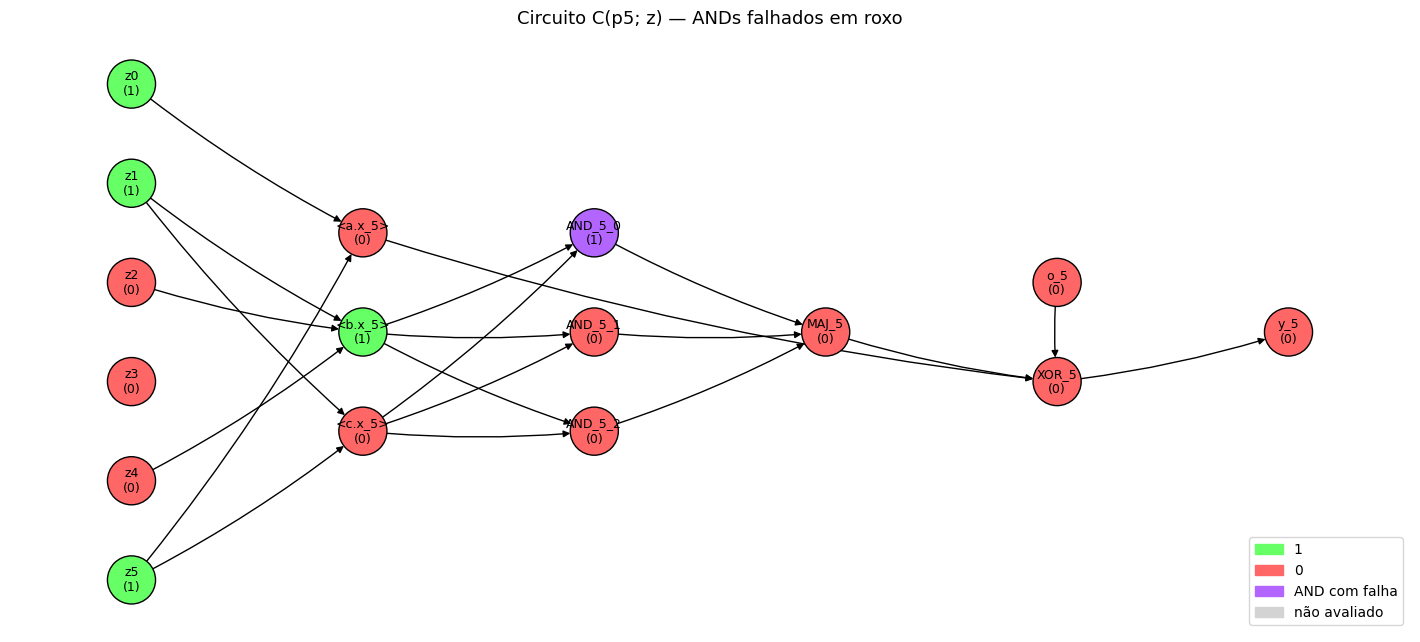


=== Circuito 5 ===
a.x = 0, b.x = 1, c.x = 0
ANDs = [1, 0, 0]
Falhas (f) = [1 0 0]
MAJ = 0, o = 0, XOR = 0, saída y = 0


In [19]:
def maximize_max_faults():
    # Geração pseudoaleatória

    s_bits = np.random.randint(0, 2, size=k, dtype=np.uint8)
    s_packed = bits_to_bytes(s_bits)

    print("Seed (bits):", s_bits)
    print("Seed (bytes):", s_packed)

    rng = np.random.RandomState(s_packed)

    a_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
    b_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)
    c_list = np.array([make_polynom(n, rng) for _ in range(m)], dtype=np.uint8)

    z_bits = make_polynom(n, rng)
    z_packed = bits_to_bytes(z_bits)

    print("z (bits) =", z_bits)
    print("z (bytes) =", z_packed)

    # Circuito base (sem falhas)
    p0_list = [(0, a_list[i], b_list[i], c_list[i]) for i in range(m)]
    o_list = [eval_f_numeric(p0_list[i], z_bits, [0,0,0]) for i in range(m)]
    p_list = [(int(o_list[i]), a_list[i], b_list[i], c_list[i]) for i in range(m)]

    # Criação de variáveis simbólicas
    z_vars = [Symbol(f"z{i}", BOOL) for i in range(n)]
    f_vars = [[Symbol(f"f{i}_{j}", BOOL) for j in range(3)] for i in range(m)]

    solver = Solver()
    constraints = []

    # Construção simbólica do circuito (com falhas)
    for i in range(n):
        constraints.append(EqualsOrIff(z_vars[i], Bool(bool(z_bits[i]))))

    for i in range(m):
        ax_symb = sum_1_symb(a_list[i], z_vars)
        bx_symb = sum_1_symb(b_list[i], z_vars)
        cx_symb = sum_1_symb(c_list[i], z_vars)

        # ANDs com falha modelada como inversão quando f=1
        and_faults = [
            Ite(f_vars[i][j],
                Not(And(bx_symb, cx_symb)),  # falha inverte o valor
                And(bx_symb, cx_symb))       # normal
            for j in range(3)
        ]

        maj_expr = maj_symb(and_faults[0], and_faults[1], and_faults[2])
        y_expr = xor_n([Bool(False), ax_symb, maj_expr])  # saída esperada

        constraints.append(EqualsOrIff(y_expr, Bool(bool(o_list[i]))))

    # Adicionar todas as constraints ao solver
    solver.add_assertion(And(constraints))

    fault_int_terms = [Ite(f_vars[i][j], Int(1), Int(0)) for i in range(m) for j in range(3)]

    low, high = 0, 3*m
    best_k = 0
    best_model = None

    while 1 < high-low:
        mid = (low + high) // 2

        solver.push()
        solver.add_assertion(Equals(Plus(fault_int_terms), Int(mid))) 
        sat = solver.solve()
        if sat:
            best_k = mid
            best_model = solver.get_model()
            low = mid 
        else:
            high = mid  
        solver.pop()
        

    solver.exit()

    # Reconstrução e impressão dos resultados
    total_ANDs = 3 * m
    p_falha = best_k / total_ANDs

    print("========================================")
    print(f"Máximo número de falhas toleradas: {best_k} / {3*m}")
    print(f"Probabilidade máxima de falha tolerada: {p_falha:.4f}")
    print("========================================")

    z_solution_bits = np.array([1 if best_model.get_value(z_vars[i]).is_true() else 0 for i in range(n)], dtype=np.uint8)
    print("z reconstruído (bits):", z_solution_bits)

    f_solution_bits = []
    for i in range(m):
        f_bits_i = np.array([1 if best_model.get_value(f_vars[i][j]).is_true() else 0 for j in range(3)],dtype=np.uint8)
        f_solution_bits.append(f_bits_i)
        print(f"faults do solver para f_vars[{i}] (bits):", f_bits_i)

    # Recalcular saídas
    o_list_from_p = [eval_f_numeric(p_list[i], z_solution_bits, f_solution_bits[i]) for i in range(m)]
    print("o_list a partir p_list com faults no AND:", o_list_from_p)

    # Plotar
    for i in range(m):
        plot_circuit(p_list[i], i, z_solution_bits, f_solution_bits)

maximize_max_faults()